# Import Libries

In [1]:
import os
import shutil
import struct
import glob
from importlib import reload
from collections import Counter

import numpy as np
import pandas as pd
import KiMoPack.plot_func as pf
import lmfit

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import min_function as mf
import min_plot as mp
import min_instrument as mins
import min_math as mm

cwd = os.getcwd()
print(f"Current Work Directory:\n{cwd}")

foldername = os.path.basename(cwd)
foldername = foldername.split(".")[0]
print(f"\nFoldername:\n{foldername}")

Current Work Directory:
/Users/tm/Downloads

Foldername:
Downloads


# Preprocess

In [ ]:
filepaths_scan = glob.glob(f"{cwd}/*/*.GUI.csv")
filepaths_scan.sort()
num_scans = len(filepaths_scan)
print(f"{num_scans} scans were found:")
for filepath_scan in filepaths_scan:
    print(os.path.basename(filepath_scan))

# shutil.rmtree("Scans")
os.makedirs(f"{cwd}/Scans", exist_ok=True)

## Process Each Scan

In [ ]:
ls_nanloc = []
ls_scan = []
# filepaths_scan = filepaths_scan[0:2]
for filepath_scan in filepaths_scan:
    print(f"\nCurrent scan:\n{os.path.basename(filepath_scan)}")

    (dir_scan, filename_scan) = os.path.split(filepath_scan)
    filename_scan = os.path.basename(filepath_scan)
    filename_scan = filename_scan.split(".")
    scan_count = ((filename_scan[1].split("_"))[-1]).lower()
    filename_scan = filename_scan[0] + "_" + scan_count
    # fn_scan = fn_scan.replace("uvvis", "caf2")
    print(f"Modified Filename:\n{filename_scan}")

    # raw data in mOD
    scan_df = pd.read_csv(
        filepath_scan, header=0, index_col=0, na_values="NaN", sep=","
    )
    scan_df.index.name = None
    scan_df = scan_df * 1000
    scan_df.columns = [float(i) for i in scan_df.columns]
    print(
        f"Raw fs-TA data, \033[1m{len(np.where(scan_df.isna())[0])} NaN point\033[0m:"
    )
    # display(scan_df)
    mp.display_fsta_heatmap(
        scan_df,
        zlimit=[-5, 5, 0.5],
    ).show()
    # mins.writeSXUfs(
    #     scan_df,
    #     f"Scans/{fn_scan}_raw.ufs",
    # )
    # mins.writeFSCsv(
    #     scan_df,
    #     f"Scans/{fn_scan}_raw.csv",
    # )

    # tailor
    wl_range = [325, 700]
    tailored_scan_df = mins.tailor_fsta(scan_df, wl_range)
    tailored_scan_df = scan_df.loc[
        (scan_df.index >= wl_range[0]) & (scan_df.index <= wl_range[1])
    ]
    print(
        f"Tailored raw fs-TA data, \033[1m{len(np.where(tailored_scan_df.isna())[0])} NaN points\033[0m:"
    )
    # display(tailored_scan_df)
    # mp.display_fsta_heatmap(tailored_scan_df, zlimit=[-5, 5, 0.5]).show()
    mins.writeSXUfs(
        tailored_scan_df,
        f"Scans/{filename_scan}_crop.ufs",
    )
    # mins.writeFSCsv(
    #     tailored_scan_df,
    #     f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}.csv",
    # )

    # nan_columns = df.isna().any()
    # display(nan_columns)
    # display(type(nan_columns))
    # nan_columns_indices = nan_columns[nan_columns].index.tolist()

    # full the line with NaN with NaN
    # nancols = tailored_scan_df.isna().any()
    # nancols = nancols[nancols].index.tolist()

    nanloc = [
        tailored_scan_df.columns.get_loc(col)
        for col in tailored_scan_df.columns
        if tailored_scan_df[col].isna().any()
    ]

    # display(nancol_locations)
    ls_nanloc.append(nanloc)
    tailored_scan_df.iloc[:, nanloc] = 0  # fill NaN with 0
    # display(tailored_scan_df)
    mp.display_fsta_heatmap(tailored_scan_df, zlimit=[-5, 5, 0.5]).show()
    ls_scan.append(tailored_scan_df)

    # repair NaN
    # rpnan_tailored_scan_df = tailored_scan_df.interpolate(
    #     method="linear", limit_direction="both", axis=0
    # )
    # print(
    #     f"Repaired tailored raw fs-TA data, \033[1m{len(np.where(rpnan_tailored_scan_df.isna())[0])} NaN point\033[0m:"
    # )
    # display(rpnan_tailored_scan_df)
    # mp.display_fsta_heatmap(rpnan_tailored_scan_df, zlimit=[-5, 5, 0.5]).show()
    # mins.writeSXUfs(
    #     rpnan_tailored_scan_df,
    #     f"Scans/{filename_scan}_crop_rna.ufs",
    # )
    # mins.writeFSCsv(
    #     tailored_scan_df,
    #     f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}_rpnan.csv",
    # )

    # store
    # ls_scan.append(rpnan_tailored_scan_df)

# nanloc.sort()

## Compare Each Scan with the First Scan


In [ ]:
reload(mp)
ref_scan_num = 0
for i in range(1, len(ls_scan)):
    scan_diff = mins.compare_scan_fsta(ls_scan[ref_scan_num], ls_scan[i])
    mp.display_fsta_heatmap_log(
        scan_diff,
        # zlimit=[-2, 2, 0.1]
    ).show()
    mins.writeSXUfs(
        scan_diff,
        f"Scans/{foldername}_diff{i}{ref_scan_num}.ufs",
    )

## Reaverage

In [ ]:
index_list = [0, 1]
ls_scan = [ls_scan[i] for i in index_list]
ls_nanloc = [ls_nanloc[i] for i in index_list]
nanlocs = []
nanlocs.extend(ls for ls in ls_nanloc)

times = []
for scan in ls_scan:
    times.append(scan.columns.values.tolist())
num_times = len(times)
av_time = []
for i in range(len(times[0])):
    sum_time = sum(time[i] for time in times)
    av_time.append(sum_time / num_times)
# display(av_time)
for scan in ls_scan:
    scan.columns = av_time
    # display(scan)

sum_scan = ls_scan[0]
for scan in ls_scan[1:]:
    sum_scan = sum_scan + scan
# display(sum_scan)
# mp.display_fsta_heatmap(sum_scan).show()
av_scan = sum_scan / num_times
# display(av_scan)
# mp.display_fsta_heatmap(av_scan).show()

counter_nancols = Counter(nanloc)
# display(counter_nancols)
for key, value in counter_nancols.items():
    av_scan.iloc[:, key] = av_scan.iloc[:, key] * (num_scans / (num_scans - value))
display(av_scan)
mp.display_fsta_heatmap(av_scan).show()
mins.writeSXUfs(
    av_scan,
    f"Scans/{foldername}_crop_rna_rav.ufs",
)

In [ ]:
# av_scan = mins.reaverage_fsta(ls_scan)
# display(av_scan)
# mp.display_fsta_heatmap(av_scan).show()
# mins.writeSXUfs(
#     av_scan,
#     f"Scans/{foldername}_crop_rna_rav.ufs",
# )

## Subtract the Background

In [ ]:
sub_bg_fsta = mins.subtract_background_fsta(av_scan, [-100, -2])
# display(sub_bg_fsta)
mp.display_fsta_heatmap(sub_bg_fsta).show()
mins.writeSXUfs(
    sub_bg_fsta,
    f"Scans/{foldername}_crop_rna_rav_sbg.ufs",
)
# mins.writeFSCsv(
#     sub_bg_fsta,
#     f"Scans/{filename}_rna_rav_sbg.csv",
# )
# mins.writeCVTsv(
#     sub_bg_fsta,
#     f"Scans/{filename}_rna_rav_sbg.tsv",
# )

# Visualize


In [2]:
sample = f"GdL1\nin MeOH"

filepath = glob.glob(f"{cwd}/*.ufs")[0]
filename = os.path.basename(filepath).split(".")[0]
print(f"Filename:\n{filename}")
df_data = mins.load_fsta(filepath)
df_data = df_data.iloc[:, 1:]
nan = np.where(df_data.isna())
display(nan)
display(df_data)
df_data.to_csv(f"{filename}.csv")

globalmax = df_data.max().max()
globalmin = df_data.min().min()
localmax = mins.tailor_fsta(df_data, [340, 675], [0.2, 8000]).max().max()
localmin = mins.tailor_fsta(df_data, [340, 675], [0.2, 8000]).min().min()
print(f"globalmax: {globalmax}")
print(f"globalmin: {globalmin}")
print(f"localmax: {localmax}")
print(f"localmin: {localmin}")

Filename:
demo_data


(array([485]), array([734]))

-98.227955    -96.227488    -94.226958    -92.229731    -90.228181    \
344.2      0.105247      0.075427     -0.093340      0.008750     -0.065890   
344.9     -0.063070      0.111235     -0.004231      0.004252      0.034199   
345.7      0.102426      0.199344      0.070433     -0.041640     -0.012258   
346.5      0.102758      0.130600     -0.007543     -0.044706     -0.111410   
347.3      0.078795      0.059553     -0.074307      0.003101      0.062036   
...             ...           ...           ...           ...           ...   
722.2      0.114709      0.062687     -0.093414      0.115838      0.095657   
723.0      0.189123      0.092973     -0.137132      0.167687      0.060580   
723.8      0.001715      0.186638     -0.078750      0.081249      0.069131   
724.6      0.058562      0.162171     -0.115939      0.009566      0.104373   
725.4      0.066312      0.115113     -0.058088      0.040712      0.016512   

       -88.228125    -86.230952    -84.228628    -82.228263    -80.229765    \
344.2     -0.202902     -0.107252     -0.045523     -0.115190     -0.198591   
344.9     -0.141564     -0.106779     -0.016005     -0.063396     -0.120561   
345.7     -0.116068     -0.070775      0.007619     -0.032982     -0.107243   
346.5     -0.150493     -0.028711      0.076697     -0.026653     -0.055302   
347.3     -0.084146     -0.087894      0.014434     -0.044388     -0.165223   
...             ...           ...           ...           ...           ...   
722.2      0.050680     -0.057859      0.103884     -0.135335     -0.050044   
723.0      0.069098     -0.162131      0.214837     -0.139444     -0.037169   
723.8      0.010153     -0.110018      0.079436     -0.121580     -0.027719   
724.6      0.088600     -0.121355      0.114740     -0.047766     -0.121787   
725.4     -0.032087     -0.204487      0.054913     -0.016287     -0.052088   

       ...   7729.778819   7759.800233   7789.785035   7819.785134  \
344.2  ...     -1.246941     -1.226588     -1.209733     -1.566408   
344.9  ...     -0.967037     -0.997288     -0.814899     -1.387743   
345.7  ...     -0.953509     -1.042306     -0.632093     -1.211075   
346.5  ...     -0.834846     -0.982438     -0.624810     -1.153831   
347.3  ...     -0.673224     -0.646907     -0.554407     -0.904043   
...    ...           ...           ...           ...           ...   
722.2  ...      0.161831     -0.006752      0.271420     -0.009945   
723.0  ...      0.257505      0.117111      0.395491     -0.031876   
723.8  ...      0.189121     -0.026068      0.217117     -0.002068   
724.6  ...      0.227595      0.175597      0.169996      0.075197   
725.4  ...      0.295112     -0.004287      0.210913      0.031313   

        7849.779969   7879.772052   7909.785492   7939.784134   7969.786724  \
344.2     -1.059562     -1.310083     -1.303689     -1.245069     -1.034670   
344.9     -1.137782     -1.175223     -1.250346     -1.177850     -1.041330   
345.7     -1.042189     -1.142161     -0.989011     -0.787669     -0.961627   
346.5     -0.845061     -0.877758     -0.814511     -0.932549     -0.882185   
347.3     -0.608265     -0.773934     -0.734550     -0.617350     -0.618612   
...             ...           ...           ...           ...           ...   
722.2      0.193225      0.036047      0.290221      0.189244      0.197837   
723.0      0.203693      0.106309      0.273896      0.217707      0.155907   
723.8      0.154320     -0.060268      0.273514      0.143129      0.155125   
724.6      0.150995      0.122396      0.408191      0.180399      0.198396   
725.4      0.225513      0.117513      0.212712      0.230112      0.369312   

        7999.780568  
344.2     -0.879553  
344.9     -1.027386  
345.7     -0.956821  
346.5     -0.716418  
347.3     -0.587336  
...             ...  
722.2      0.240235  
723.0      0.184503  
723.8      0.098527  
724.6      0.194596  
725.4           NaN  

[486 rows x 735 columns]

globalmax: 4.7799212
globalmin: -1.9423549
localmax: 4.7799212
localmin: -1.9423549


## 2D Map


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/tm/Downloads/min_function.py:688: RuntimeWarning: divide by zero encountered in divide
  e3cm1 = 10**4 / nm


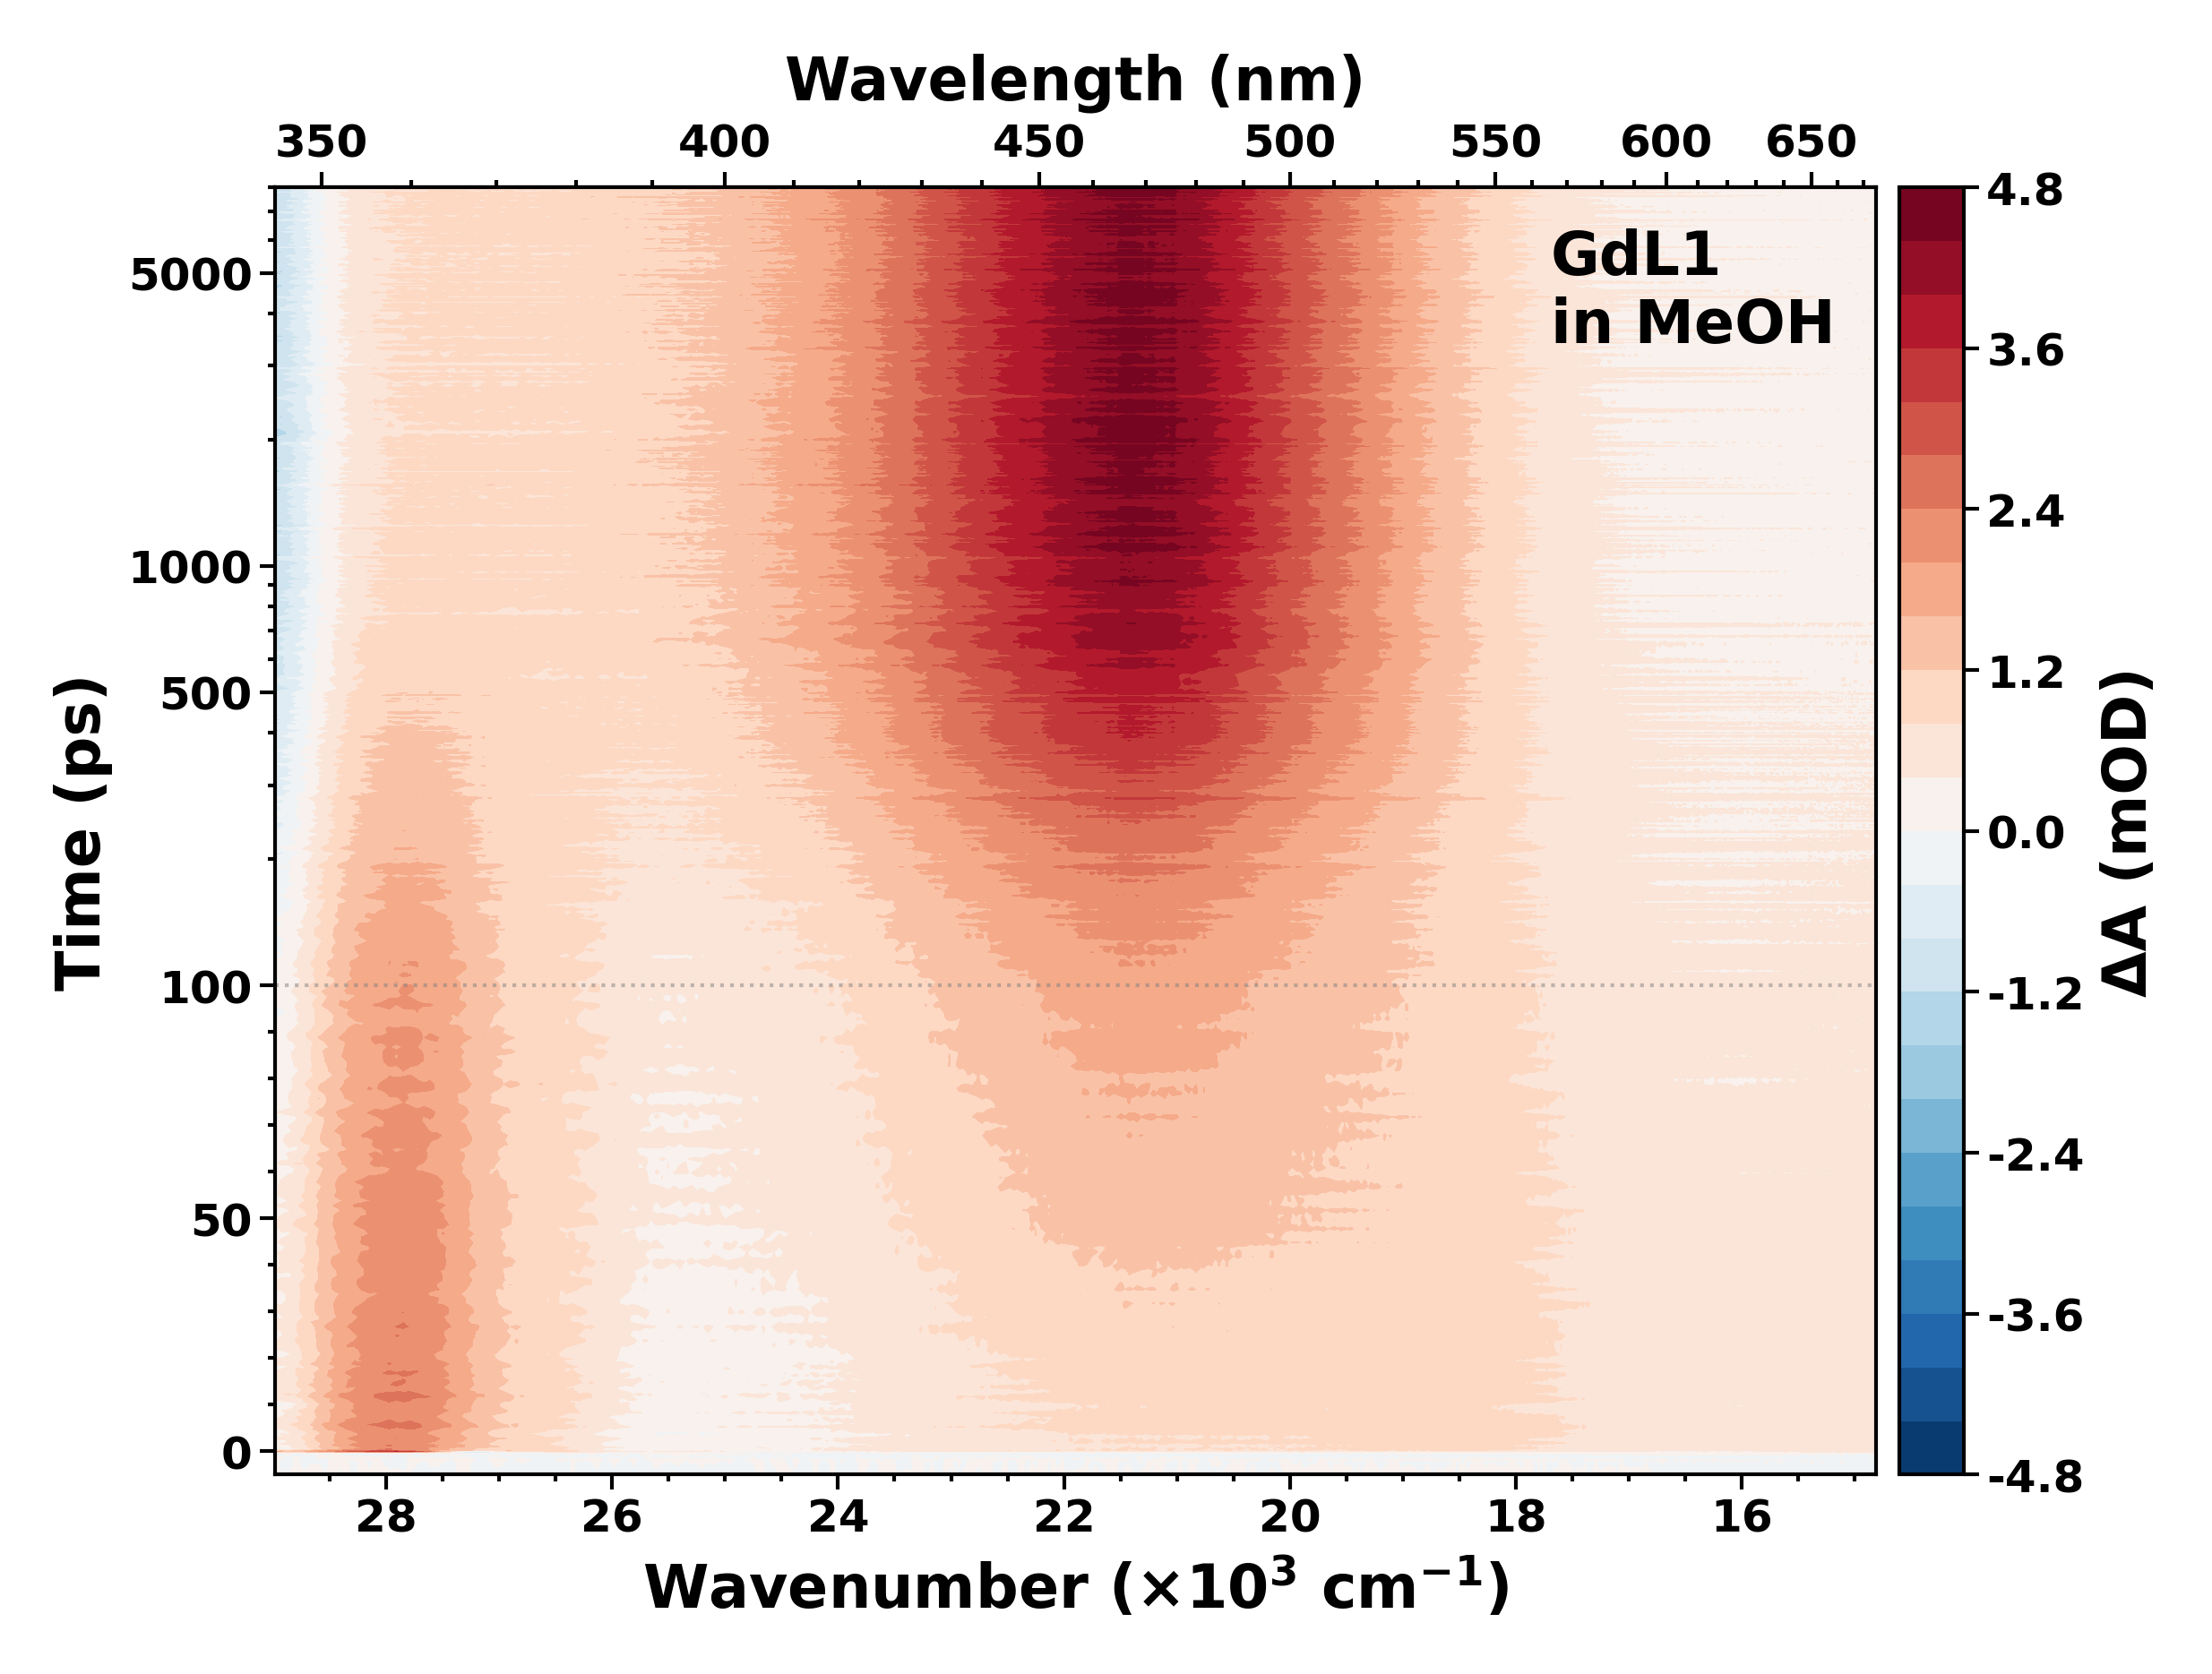

In [3]:
reload(mp)
# mp.display_fsta_heatmap_linear(df_data).show()
# mp.display_fsta_heatmap_log_v2(data, ylimit=[[np.log10(0.5), np.log10(
# 7000)], 1, 0.1]).show()

nm_limit = [[345, 675], 50, 10]
e3cm1_limit = [
    [mf.e3cm1_to_nm(nm_limit[0][0]), mf.e3cm1_to_nm(nm_limit[0][1])],
    2,
    0.5,
]
t_limit = [[-5, 100, 8000], 50, 10]
od_limit = [[-localmax, localmax], 1, 0.5]

fig_contour = mp.display_fsta_contourf_symlog_be3cm1_tnm(
    df_fsta=df_data,
    legendtitle=sample,
    xlimit=e3cm1_limit,
    xlimit2=nm_limit,
    ylimit=t_limit,
    zlimit=od_limit,
)
plt.show()
fig_contour.savefig(f"{filename}_contour.svg")

## Spectra


0.370058     75.769543    199.774744   457.772177   1499.784590  \
344.2     0.077331     0.160123    -0.465179    -1.005242    -1.181785   
344.9     0.129658     0.241657    -0.296765    -0.840639    -1.173624   
345.7     0.191983     0.222928    -0.041174    -0.792694    -1.037941   
346.5     0.225435     0.417797    -0.052115    -0.665909    -0.841862   
347.3     0.478926     0.521302     0.131286    -0.518752    -0.697774   
...            ...          ...          ...          ...          ...   
722.2     0.384748     0.405941     0.386503     0.190969     0.119456   
723.0     0.386255     0.395796     0.417341     0.135340     0.257099   
723.8     0.356982     0.278116     0.235427     0.162936     0.148318   
724.6     0.321578     0.429712     0.350628     0.150026     0.190192   
725.4     0.258512     0.322113     0.438713     0.215312     0.245113   

       1709.783250  3499.799045  7369.794051  
344.2    -1.092165    -1.436161    -1.205961  
344.9    -1.062418    -1.212179    -0.887486  
345.7    -0.808688    -1.012865    -0.917019  
346.5    -0.722810    -1.059195    -0.926613  
347.3    -0.518340    -0.924934    -0.616941  
...            ...          ...          ...  
722.2     0.442969     0.161653     0.437222  
723.0     0.291463     0.115107     0.482294  
723.8     0.385693     0.112529     0.349525  
724.6     0.488175     0.125596     0.428994  
725.4     0.397913     0.149113     0.360312  

[486 rows x 8 columns]

0.370058     75.769543    199.774744   457.772177   1499.784590  \
344.2     0.077331     0.160123    -0.465179    -1.005242    -1.181785   
344.9     0.129658     0.241657    -0.296765    -0.840639    -1.173624   
345.7     0.191983     0.222928    -0.041174    -0.792694    -1.037941   
346.5     0.225435     0.417797    -0.052115    -0.665909    -0.841862   
347.3     0.478926     0.521302     0.131286    -0.518752    -0.697774   
...            ...          ...          ...          ...          ...   
722.2     0.384748     0.405941     0.386503     0.190969     0.119456   
723.0     0.386255     0.395796     0.417341     0.135340     0.257099   
723.8     0.356982     0.278116     0.235427     0.162936     0.148318   
724.6     0.321578     0.429712     0.350628     0.150026     0.190192   
725.4     0.258512     0.322113     0.438713     0.215312     0.245113   

       1709.783250  3499.799045  7369.794051  
344.2    -1.092165    -1.436161    -1.205961  
344.9    -1.062418    -1.212179    -0.887486  
345.7    -0.808688    -1.012865    -0.917019  
346.5    -0.722810    -1.059195    -0.926613  
347.3    -0.518340    -0.924934    -0.616941  
...            ...          ...          ...  
722.2     0.442969     0.161653     0.437222  
723.0     0.291463     0.115107     0.482294  
723.8     0.385693     0.112529     0.349525  
724.6     0.488175     0.125596     0.428994  
725.4     0.397913     0.149113     0.360312  

[486 rows x 8 columns]

/Users/tm/Downloads/min_function.py:688: RuntimeWarning:

divide by zero encountered in divide



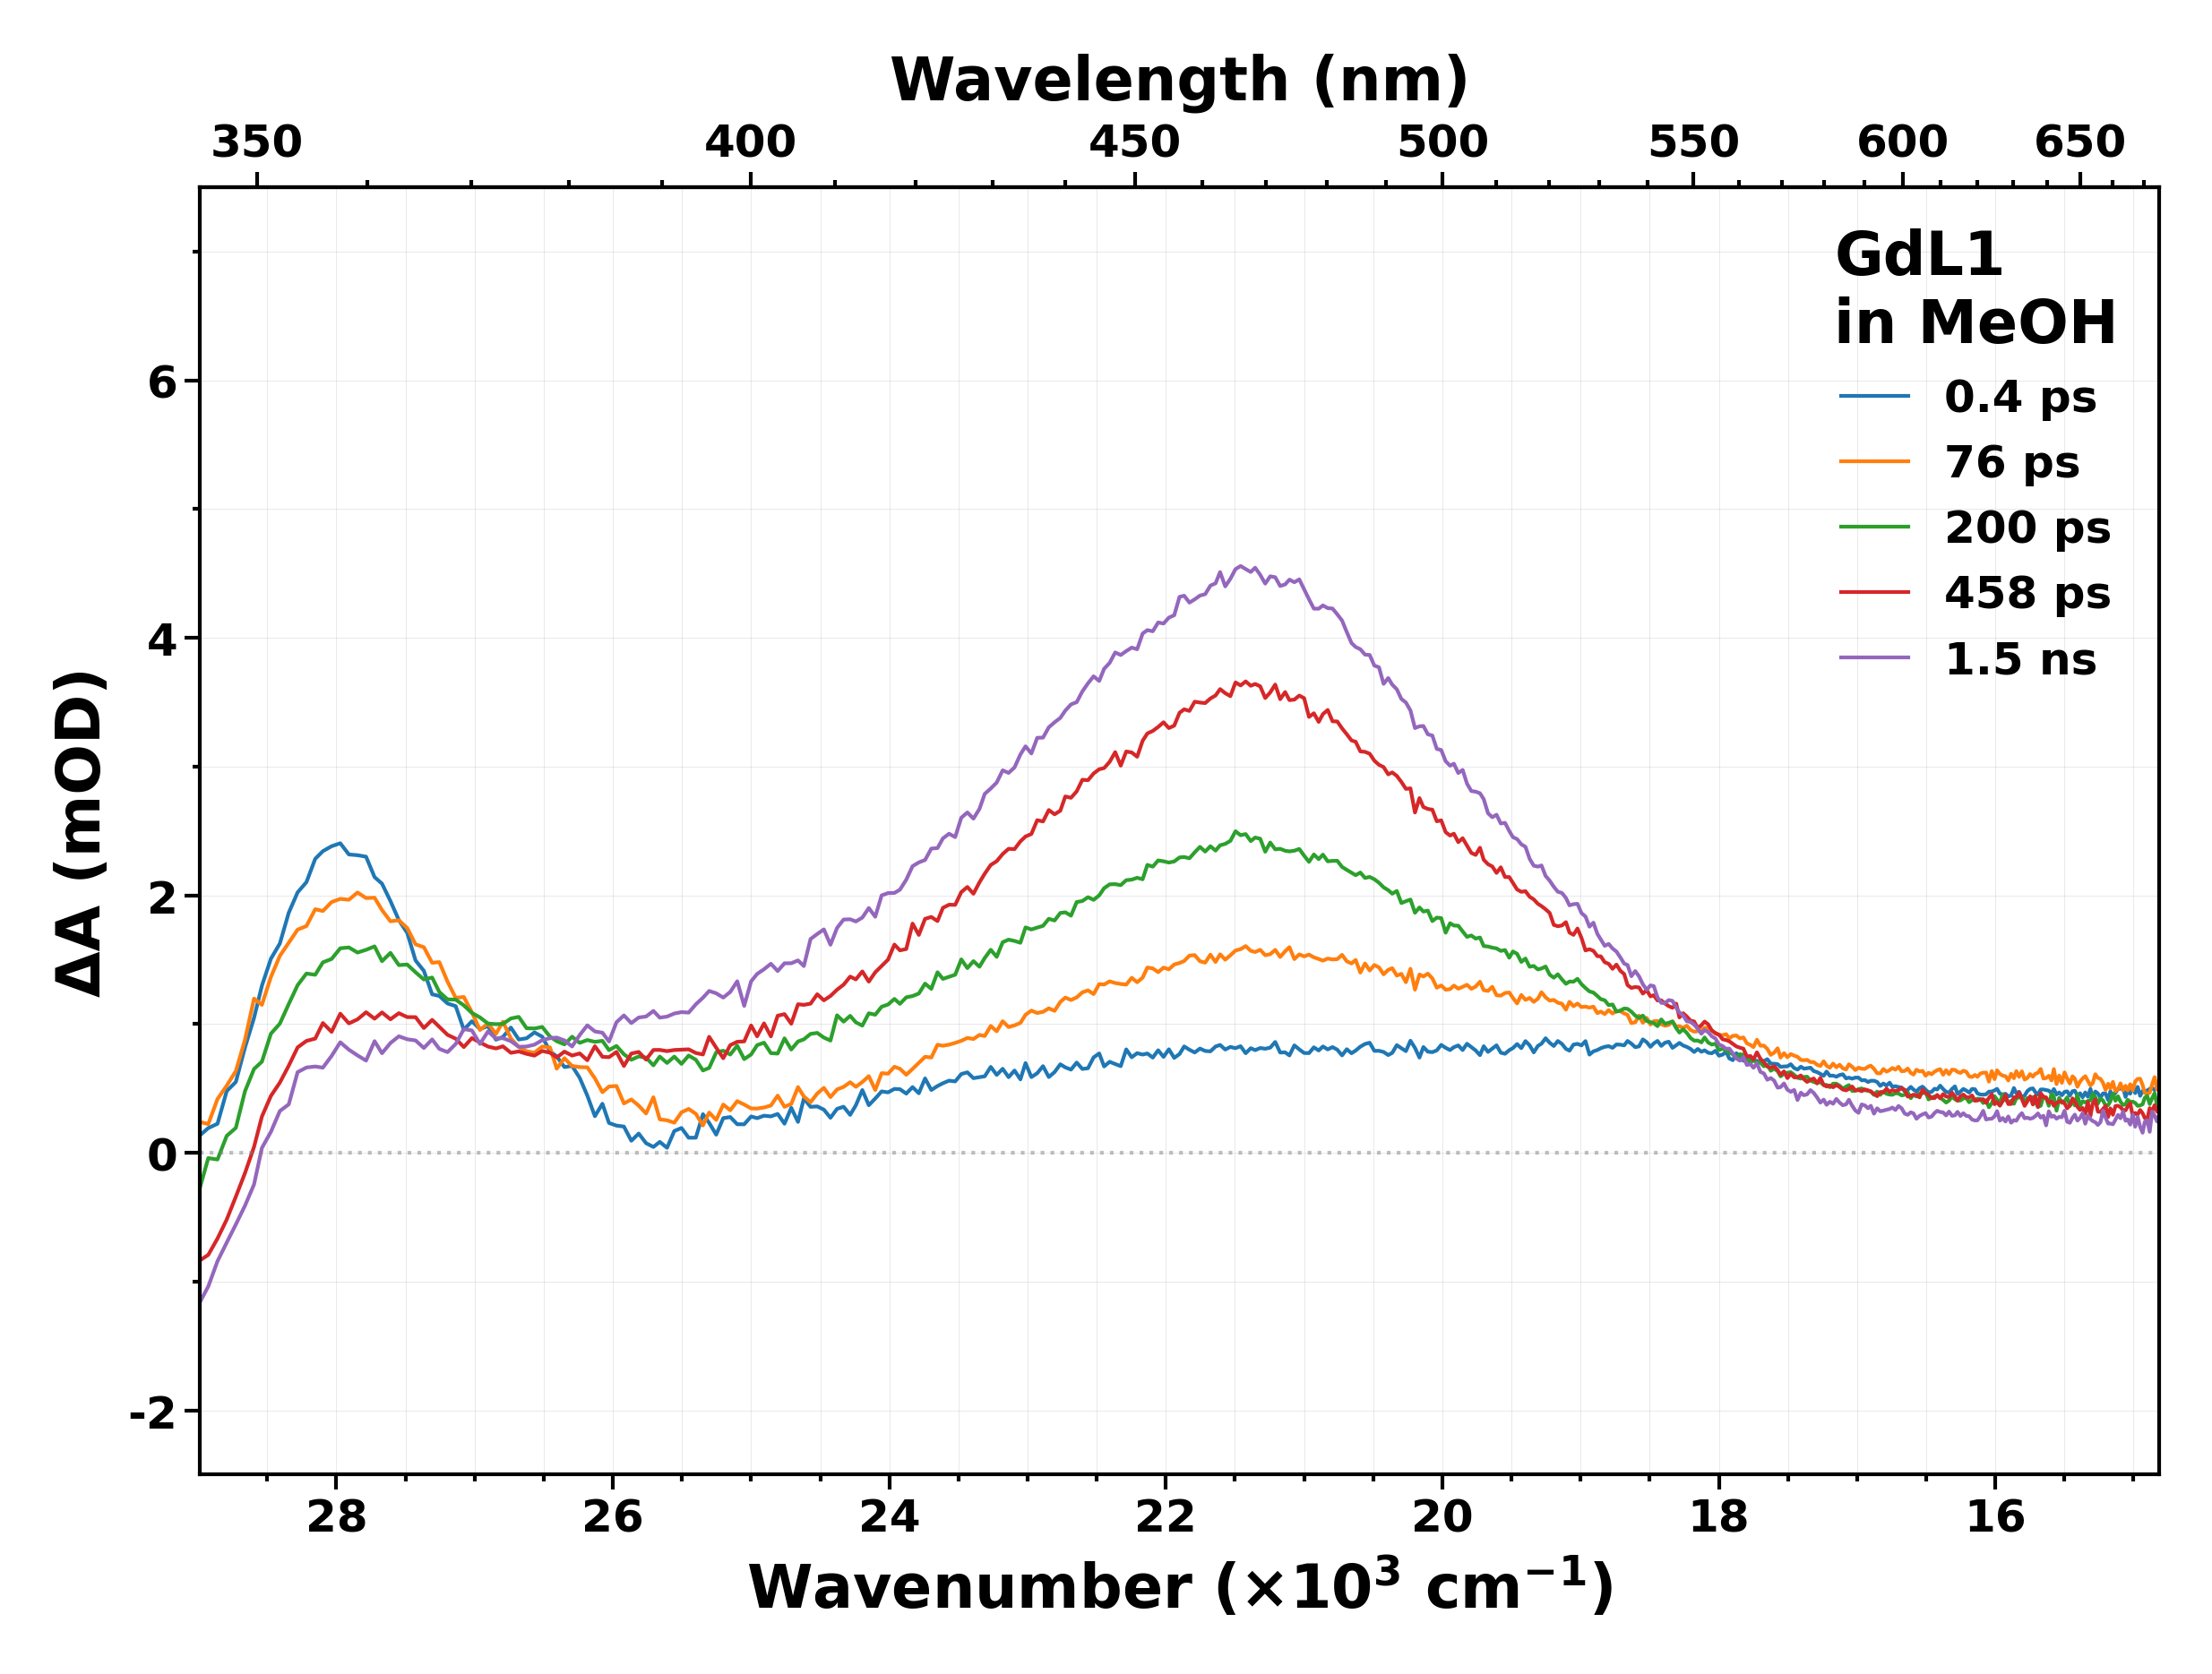

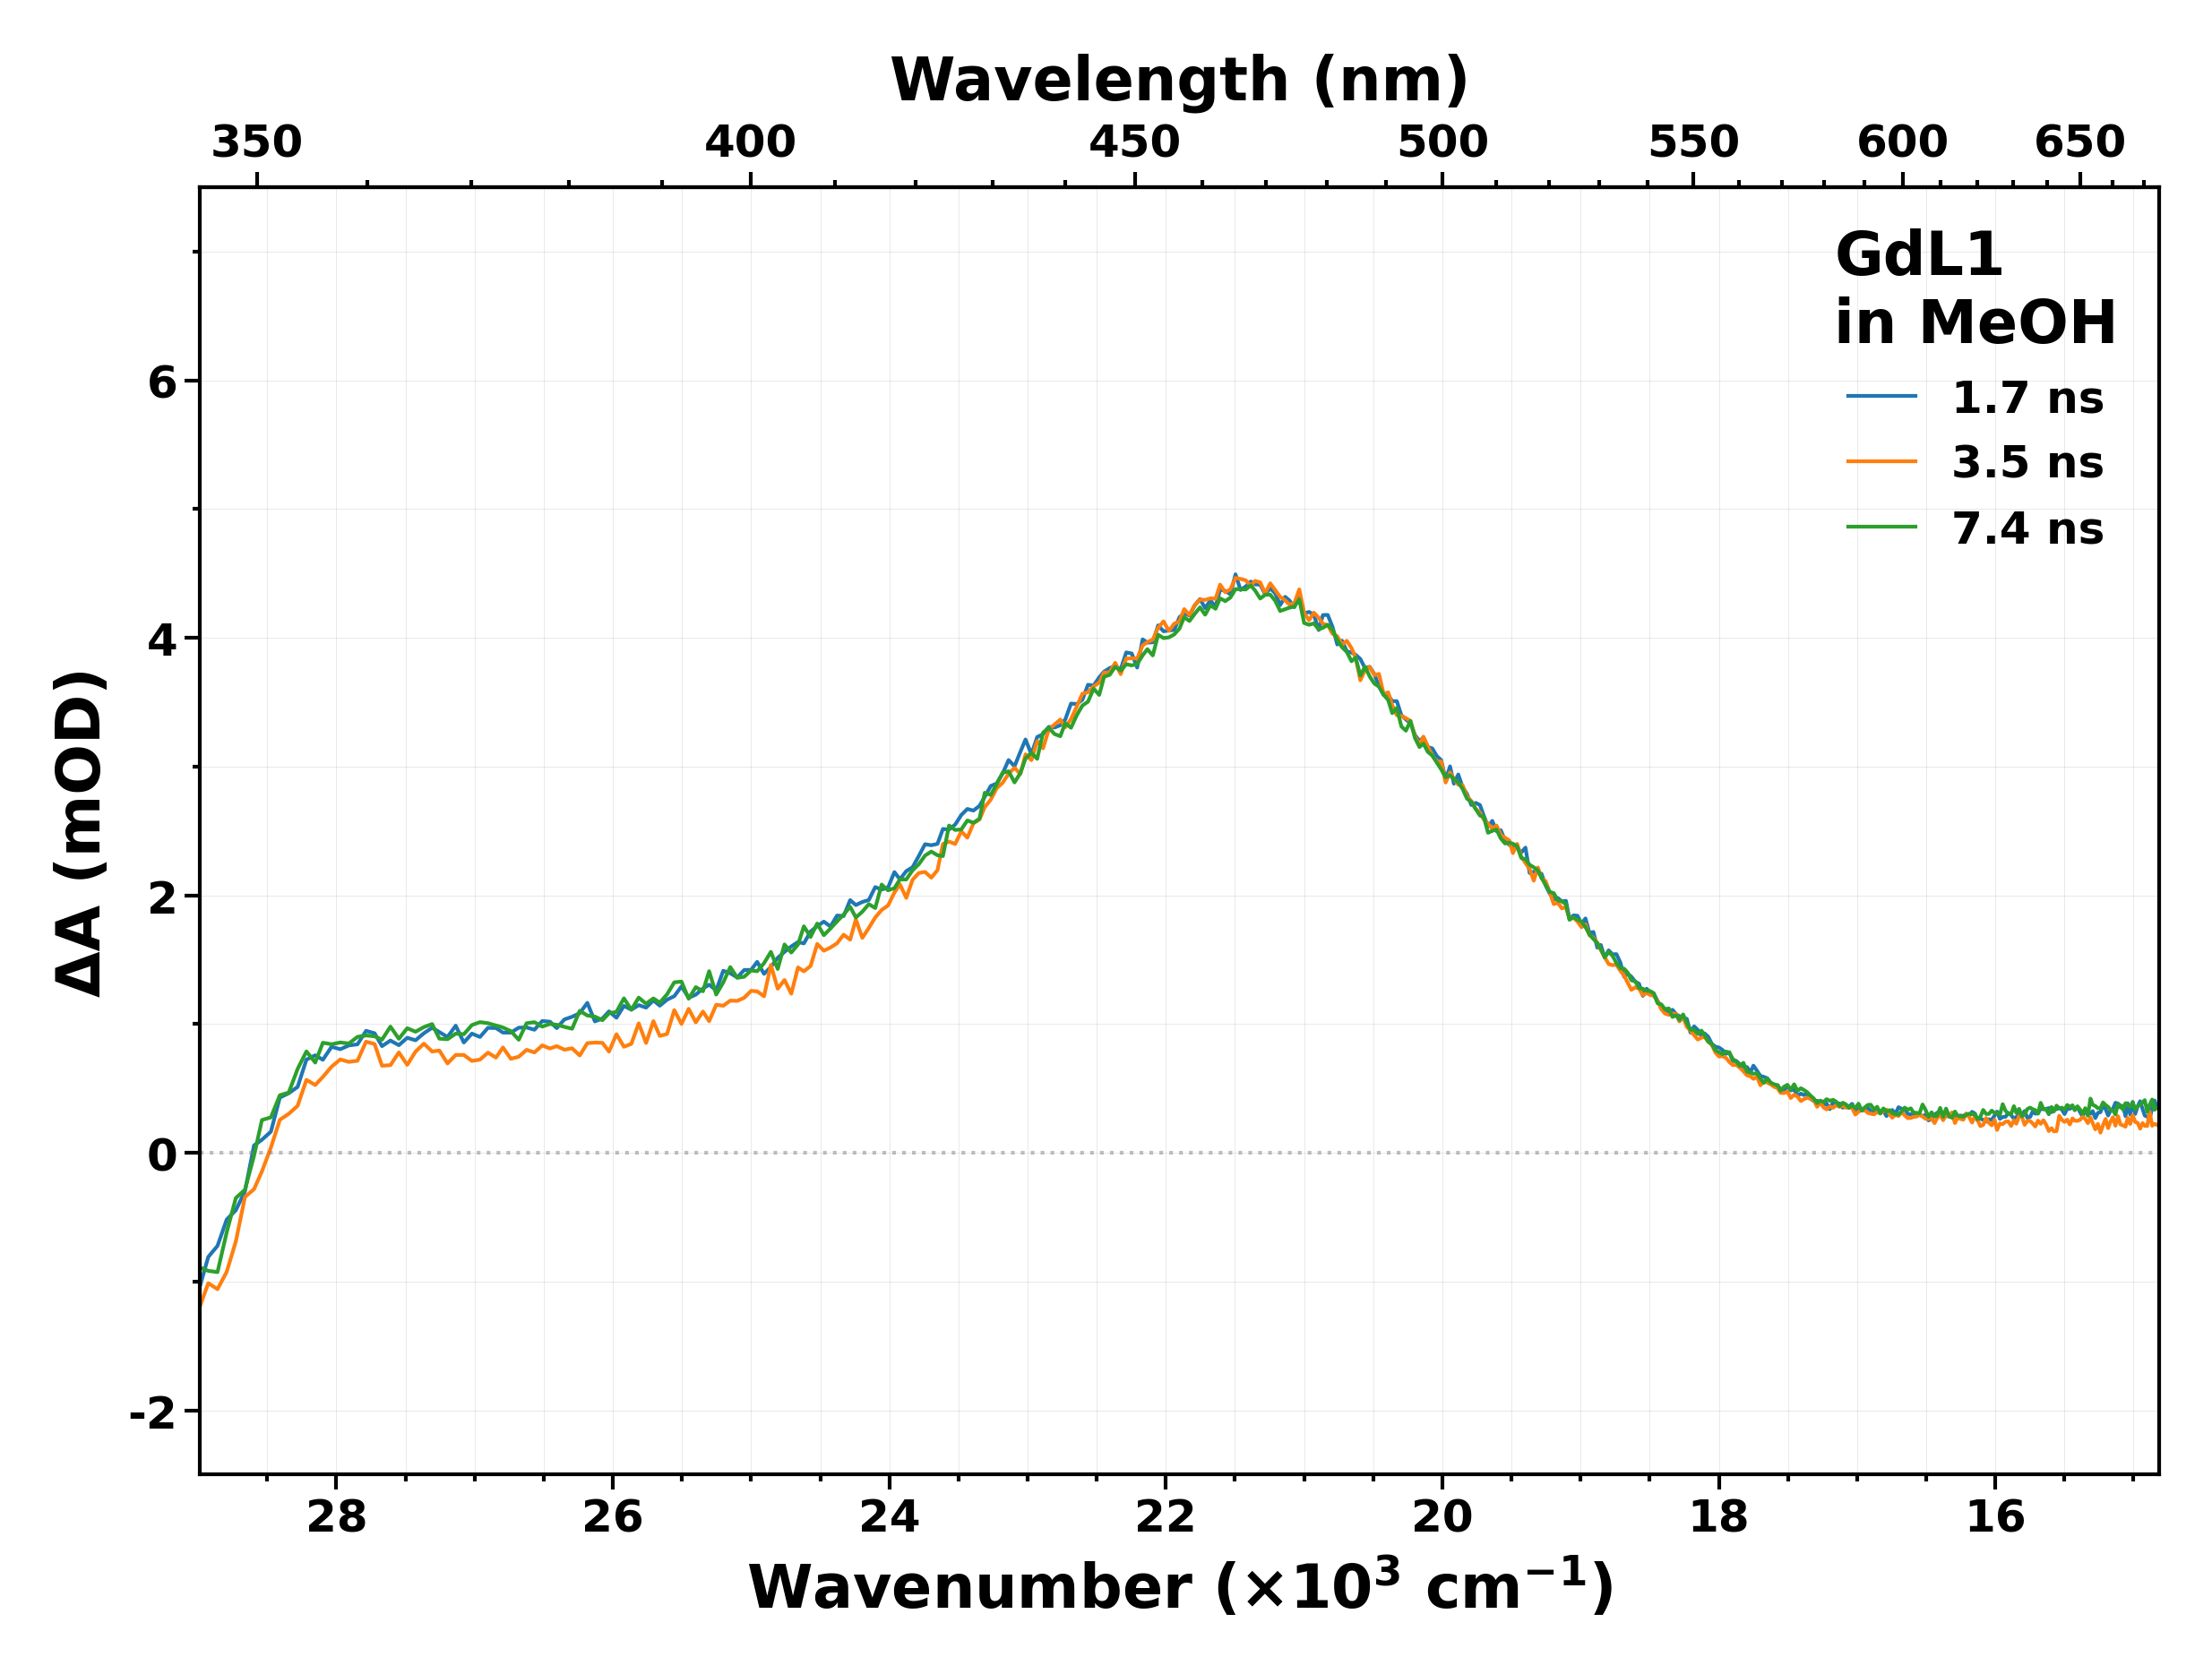

In [4]:
reload(mp)

spectra_od_limit = [[-2.5, 7.5], 2, 1]

time_delays = [0.445, 75.3, 200, 457, 1500, 1710, 3490, 7370]
df_spectra = mins.extract_spectra_trspectra(df_data, time_delays)
display(df_spectra)
mp.preview_1coldf_v2(df_spectra, showninwn=True)
df_spectra.to_csv(f"{filename}_spectra.csv", index_label="wl_nm")

fig_spectra1 = mp.display_fsta_spectra_be3cm1_tnm(
    df_fstas_wl=df_spectra.iloc[:, :5],
    legendtitle=sample,
    xlimit=e3cm1_limit,
    ylimit=spectra_od_limit,
)
plt.show()
fig_spectra1.savefig(f"{filename}_spectra1.svg")

fig_spectra2 = mp.display_fsta_spectra_be3cm1_tnm(
    df_fstas_wl=df_spectra.iloc[:, 5:],
    legendtitle=sample,
    xlimit=e3cm1_limit,
    ylimit=spectra_od_limit,
)
plt.show()
fig_spectra2.savefig(f"{filename}_spectra2.svg")

## Kinetics


356.7     472.3
-98.227955    0.071047  0.028201
-96.227488    0.142548 -0.023431
-94.226958    0.027657 -0.048016
-92.229731    0.030392  0.022563
-90.228181    0.047085 -0.029644
...                ...       ...
 7879.772052  0.695466  4.430050
 7909.785492  0.691461  4.447825
 7939.784134  0.773775  4.459093
 7969.786724  0.711737  4.482165
 7999.780568  0.742003  4.508531

[735 rows x 2 columns]

356.7     472.3
-98.227955    0.071047  0.028201
-96.227488    0.142548 -0.023431
-94.226958    0.027657 -0.048016
-92.229731    0.030392  0.022563
-90.228181    0.047085 -0.029644
...                ...       ...
 7879.772052  0.695466  4.430050
 7909.785492  0.691461  4.447825
 7939.784134  0.773775  4.459093
 7969.786724  0.711737  4.482165
 7999.780568  0.742003  4.508531

[735 rows x 2 columns]

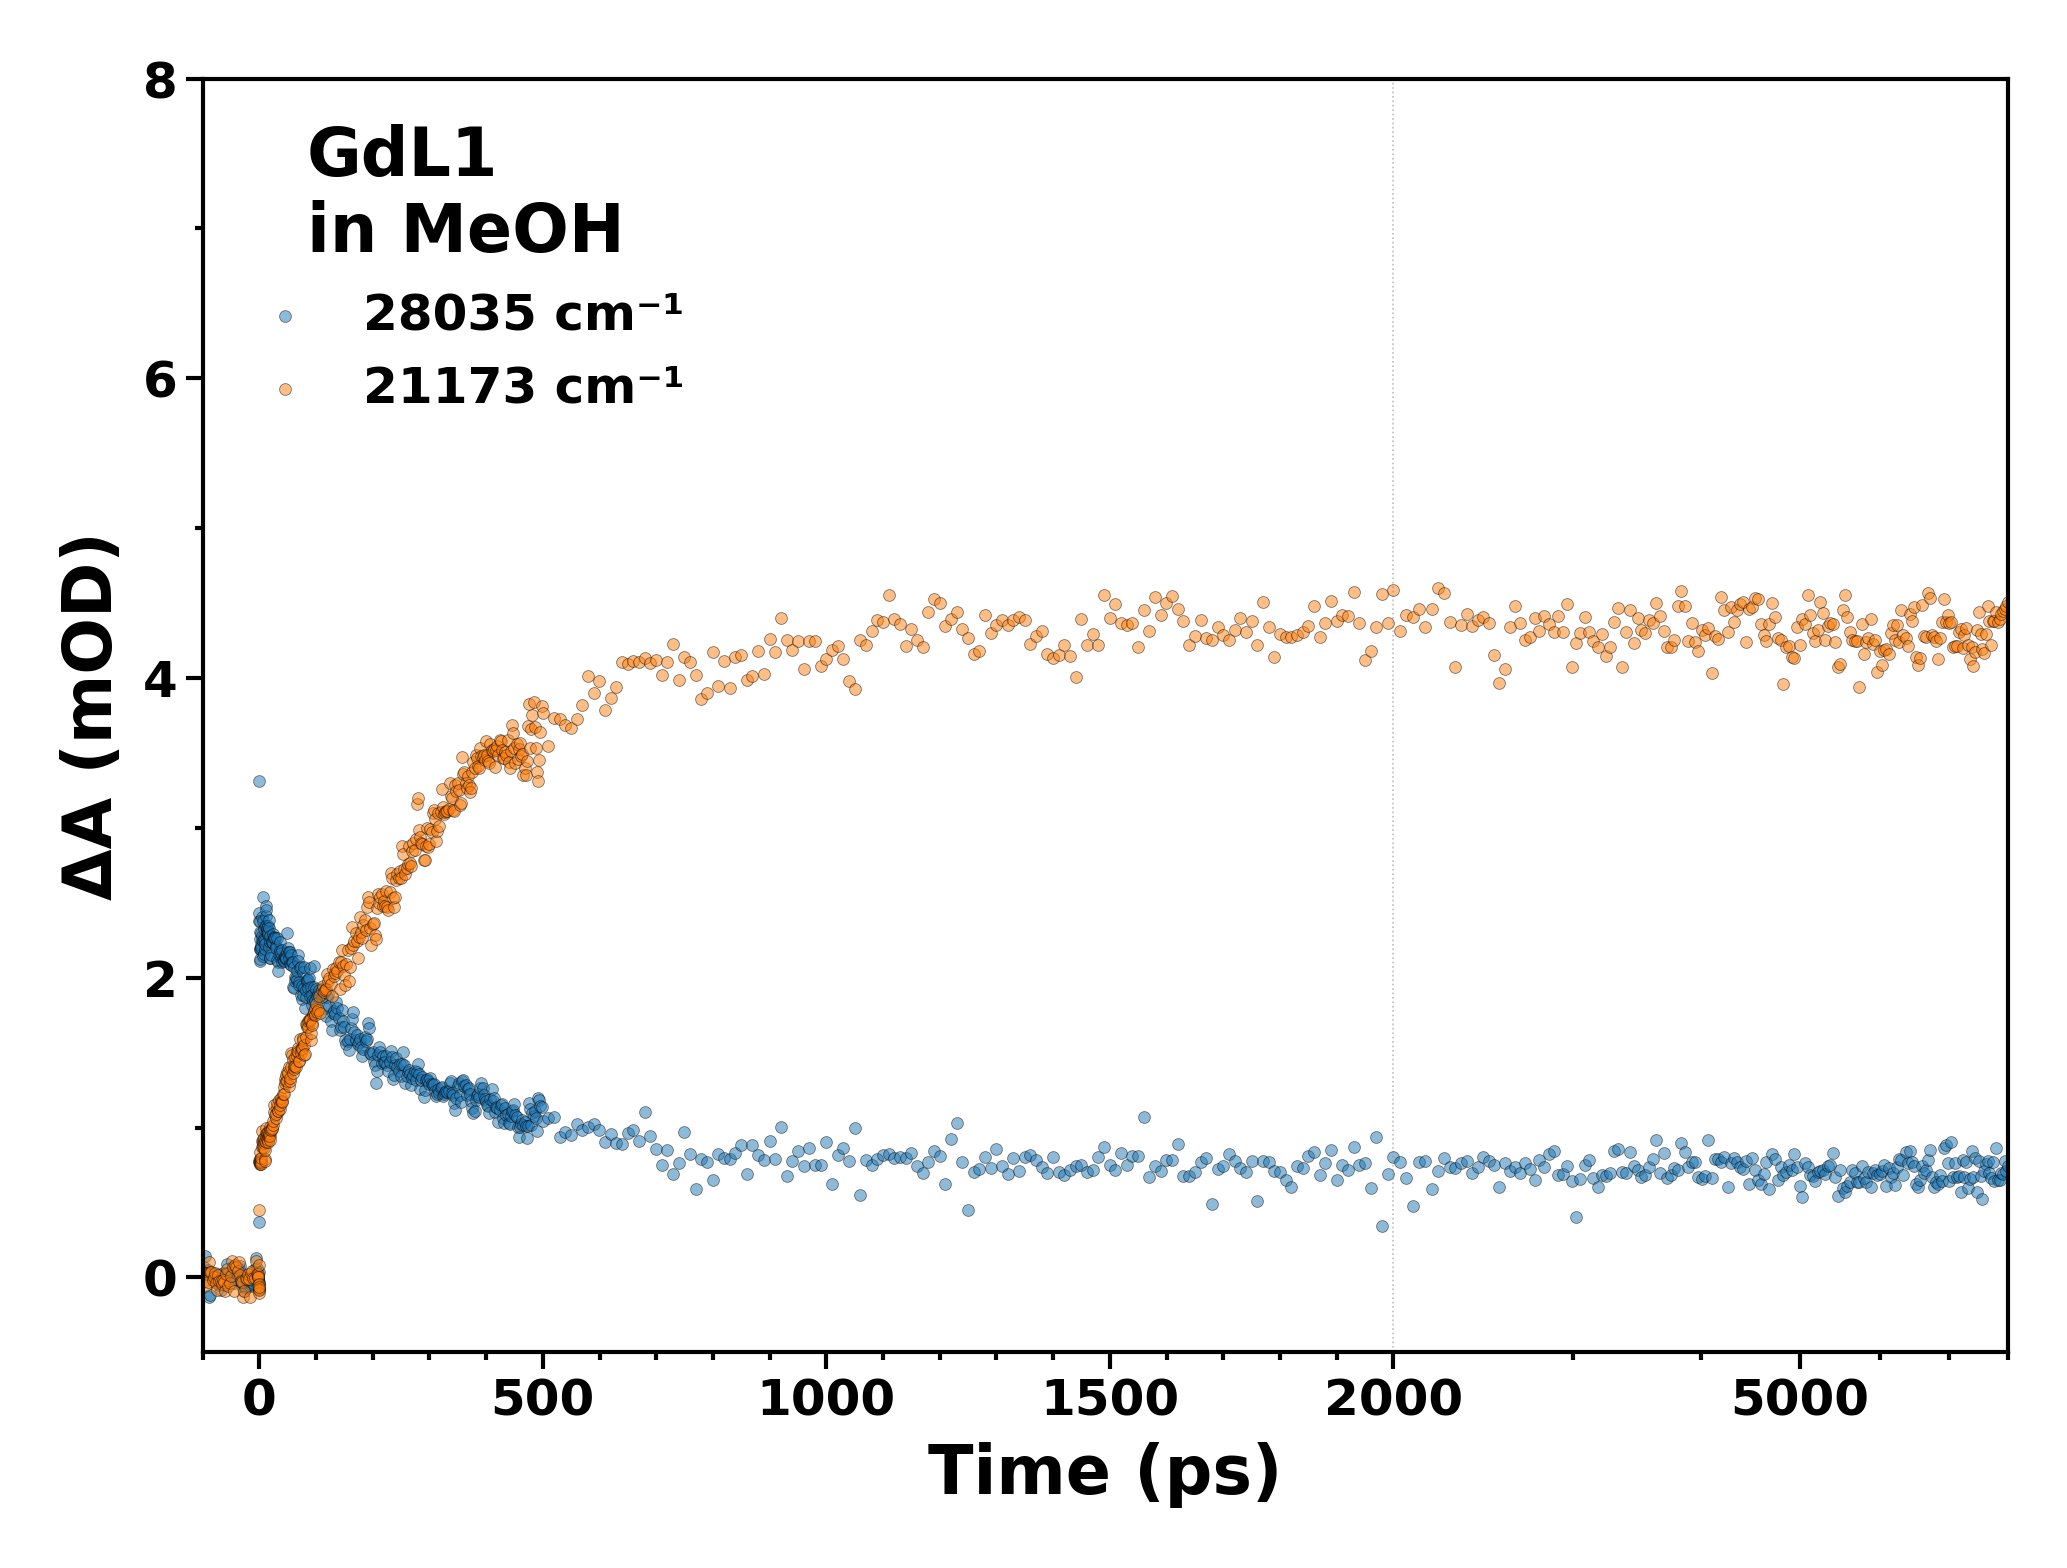

In [5]:
kinetics_t_limit = [[-100, 2000, 8000], 500, 100]
kinetics_od_limit = [[-0.5, 8], 2, 1]

wavelengths = [357, 472]
df_kinetics = mins.extract_1colkinetics_trspectra(df_data, wavelengths)
display(df_kinetics)
mp.preview_1coldf_v2(df_1col=df_kinetics, mode="markers", ylimit=kinetics_od_limit)
df_kinetics.to_csv(f"{filename}_kinetics.csv", index=True, index_label="time_ps")

fig_fstak = mp.display_fsta_1colkinetics_symlog(
    df_1col=df_kinetics,
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendtitle=sample,
    legendposition="upper left",
    showwn=True,
)
plt.show()
fig_fstak.savefig(f"{filename}_kinetics.svg")

# Single wavelength fitting


In [7]:
func = "GPdfConHDExp"

fits = []
for i in range(int((mf.reshape_1colto2col(df_kinetics)).shape[1] / 2)):
    fit = mm.fit_fsta_2colkinetics(
        data=(mf.reshape_1colto2col(df_kinetics)).iloc[:, [2 * i, 2 * i + 1]],
        func_name=func,
        p0=[0, 0, 0.05, 5, 300, 0.5, 50000],
        yaxistype="linear",
    )
    fits.append(fit[0])

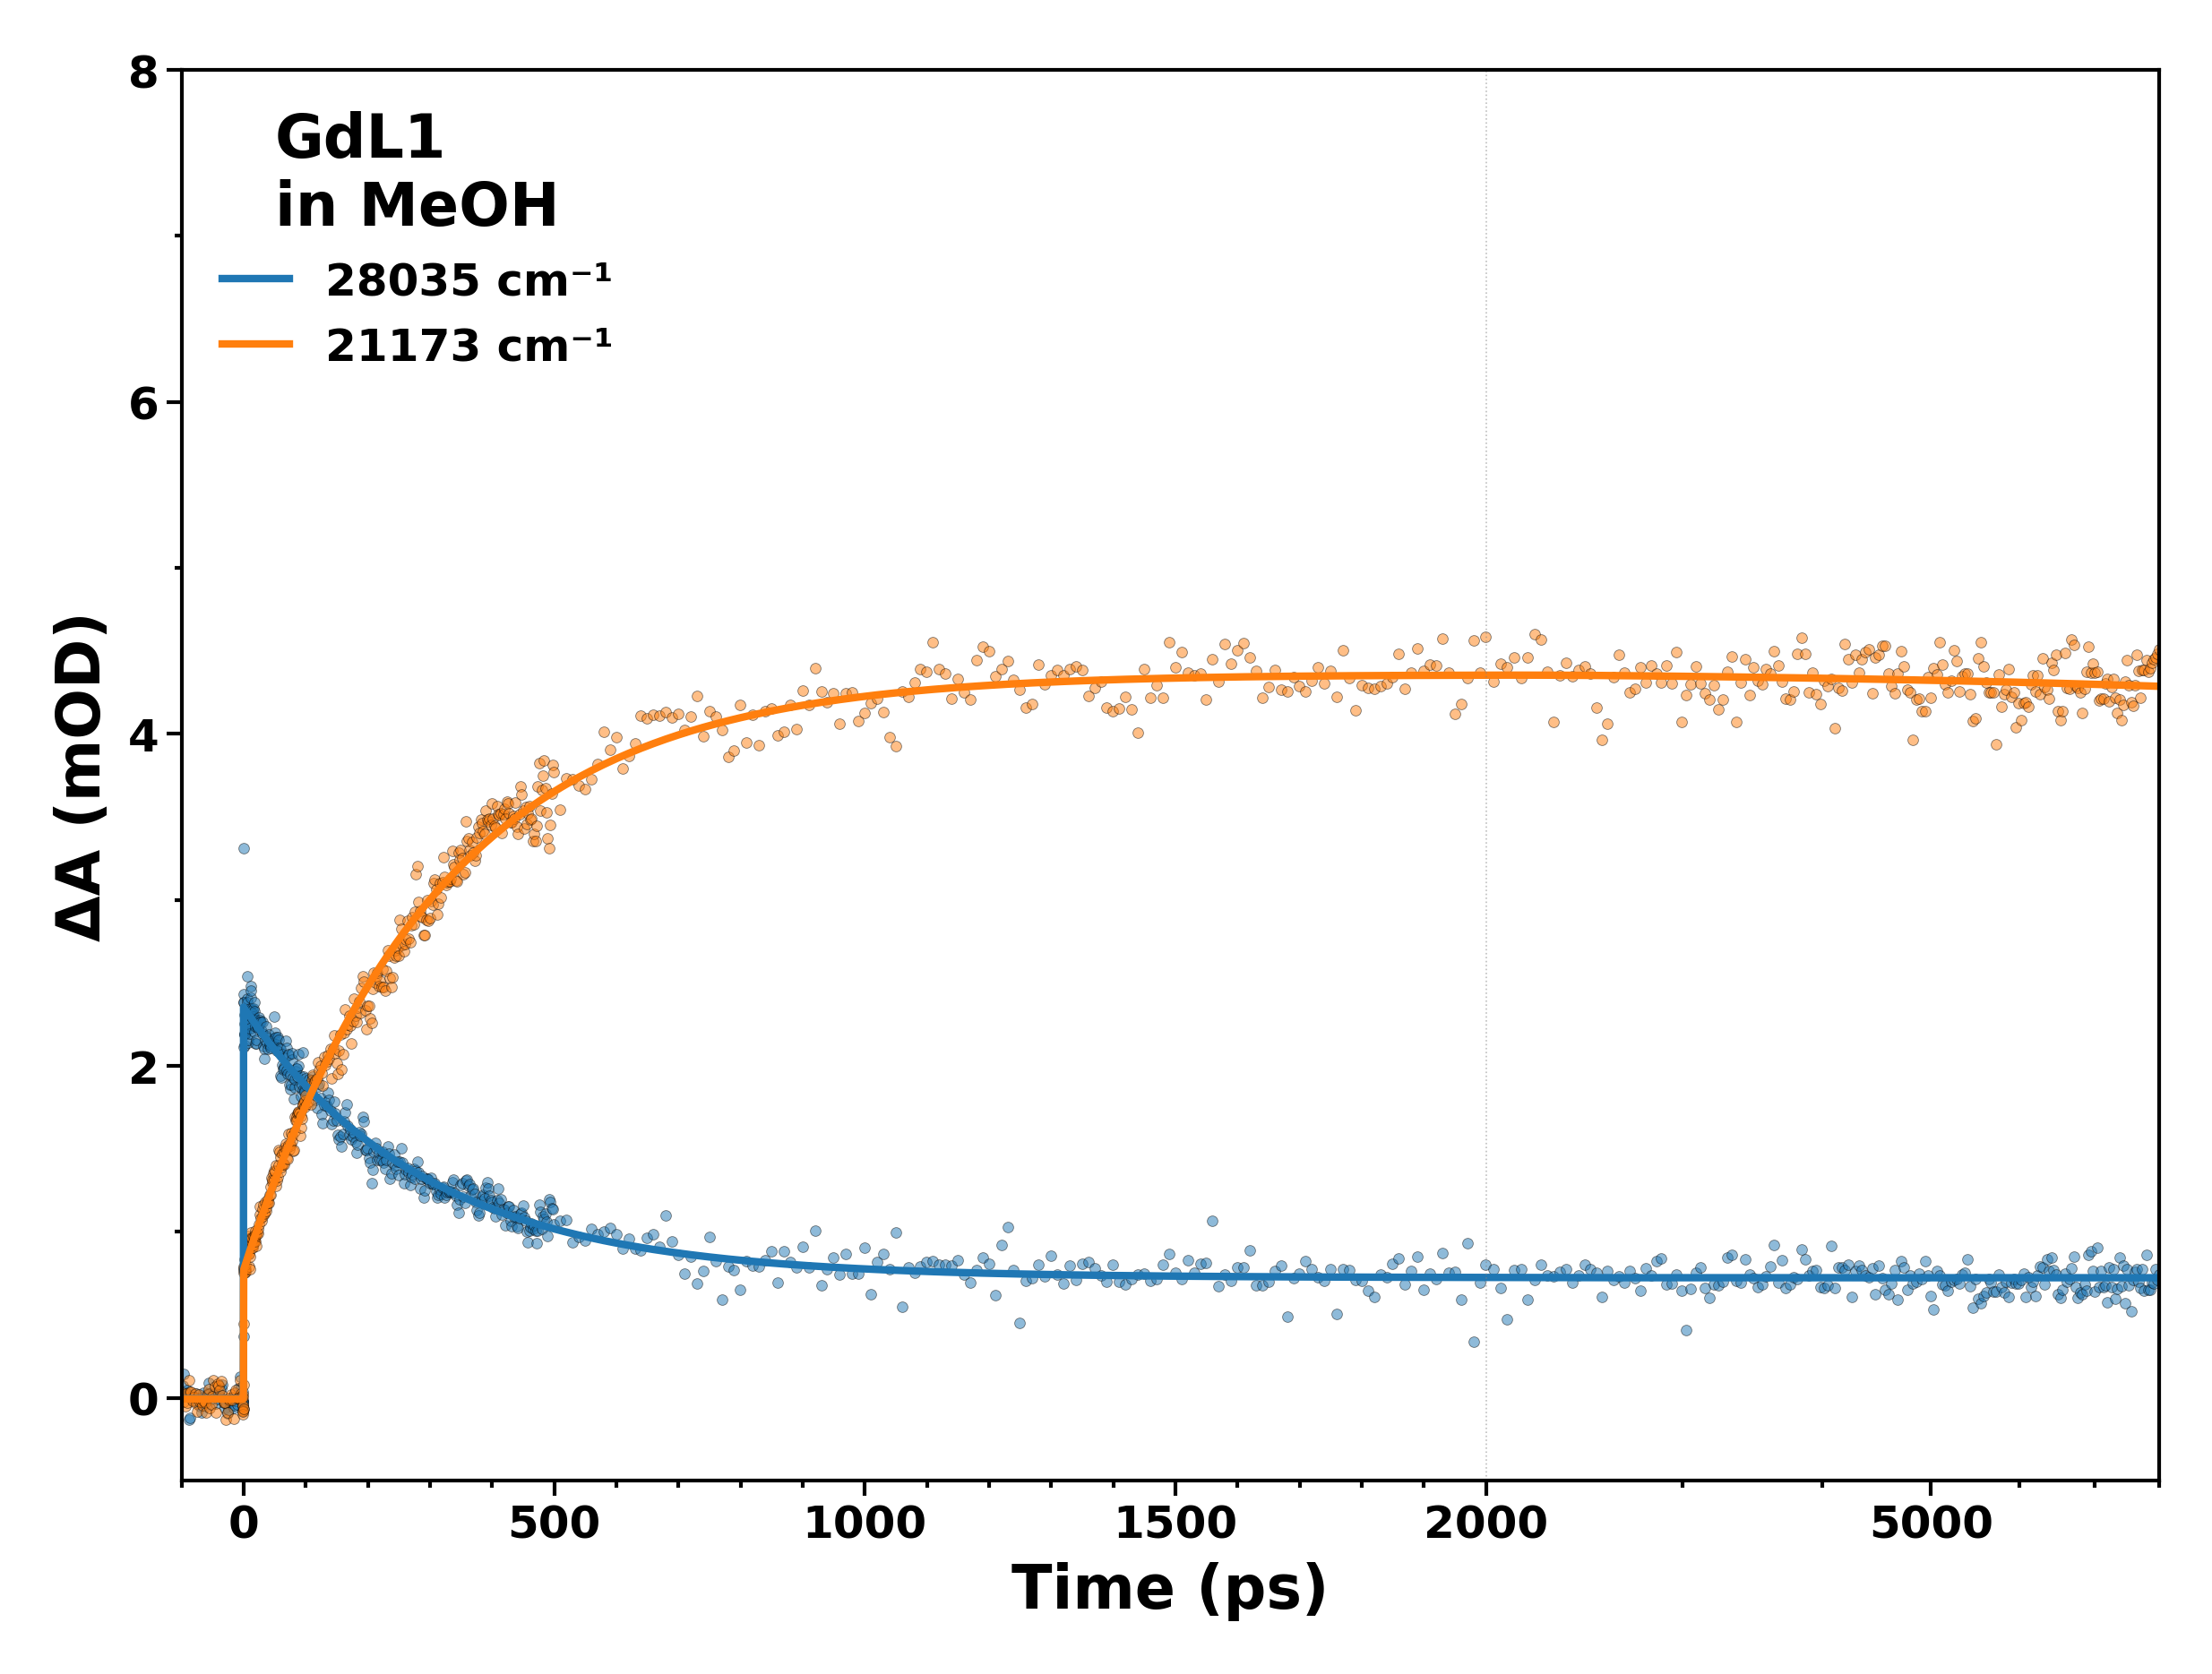

In [8]:
fig_kinetics_sfit = mp.display_fsta_1colkinetics_fitted_symlog(
    fits,
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendtitle=sample,
    legendposition="upper left",
    showwn=True,
)
plt.show()
fig_kinetics_sfit.savefig(f"{filename}_kinetics_sfit.svg")

# Global Analysis


Wavelength in nm     344.2     344.9     345.7     346.5     347.3     348.1  \
Time in ps                                                                     
-98.227955        0.105247 -0.063070  0.102426  0.102758  0.078795  0.115655   
-96.227488        0.075427  0.111235  0.199344  0.130600  0.059553 -0.010504   
-94.226958       -0.093340 -0.004231  0.070433 -0.007543 -0.074307 -0.086304   
-92.229731        0.008750  0.004252 -0.041640 -0.044706  0.003101  0.026866   
-90.228181       -0.065890  0.034199 -0.012258 -0.111410  0.062036 -0.008273   
...                    ...       ...       ...       ...       ...       ...   
 7879.772052     -1.310083 -1.175223 -1.142161 -0.877758 -0.773934 -0.600080   
 7909.785492     -1.303689 -1.250346 -0.989011 -0.814511 -0.734550 -0.368406   
 7939.784134     -1.245069 -1.177850 -0.787669 -0.932549 -0.617350 -0.376579   
 7969.786724     -1.034670 -1.041330 -0.961627 -0.882185 -0.618612 -0.520442   
 7999.780568     -0.879553 -1.027386 -0.956821 -0.716418 -0.587336 -0.402609   

Wavelength in nm     348.9     349.7     350.4     351.2  ...     718.3  \
Time in ps                                                ...             
-98.227955        0.140437  0.087673 -0.037304 -0.014868  ...  0.136725   
-96.227488        0.092585  0.064222  0.065716  0.033910  ...  0.081907   
-94.226958       -0.062770 -0.045092  0.027965 -0.029344  ... -0.128160   
-92.229731       -0.030918  0.067883  0.066791 -0.100520  ...  0.141205   
-90.228181        0.080270  0.110422  0.052388  0.004181  ...  0.016258   
...                    ...       ...       ...       ...  ...       ...   
 7879.772052     -0.353940  0.010273 -0.009729  0.102586  ...  0.204183   
 7909.785492     -0.245752 -0.044359  0.054737  0.118789  ...  0.173992   
 7939.784134     -0.306775 -0.068334  0.031810  0.200465  ...  0.167788   
 7969.786724     -0.153480 -0.039886 -0.002916  0.209685  ...  0.306968   
 7999.780568     -0.253931 -0.088893  0.132558  0.159783  ...  0.267793   

Wavelength in nm     719.1     719.9     720.6     721.4     722.2     723.0  \
Time in ps                                                                     
-98.227955        0.146783  0.140182  0.123272  0.072356  0.114709  0.189123   
-96.227488        0.121907  0.111948  0.128718  0.134747  0.062687  0.092973   
-94.226958       -0.050412 -0.110728 -0.050818 -0.054954 -0.093414 -0.137132   
-92.229731        0.112146  0.077584  0.159623  0.132997  0.115838  0.167687   
-90.228181        0.119645  0.119630  0.017728  0.015960  0.095657  0.060580   
...                    ...       ...       ...       ...       ...       ...   
 7879.772052      0.221052  0.131916  0.095943  0.053433  0.036047  0.106309   
 7909.785492      0.202061  0.337077  0.237312  0.226807  0.290221  0.273896   
 7939.784134      0.264050  0.227112  0.142534  0.148027  0.189244  0.217707   
 7969.786724      0.207266  0.321489  0.211918  0.196417  0.197837  0.155907   
 7999.780568      0.186261  0.095525  0.246322  0.210820  0.240235  0.184503   

Wavelength in nm     723.8     724.6     725.4  
Time in ps                                      
-98.227955        0.001715  0.058562  0.066312  
-96.227488        0.186638  0.162171  0.115113  
-94.226958       -0.078750 -0.115939 -0.058088  
-92.229731        0.081249  0.009566  0.040712  
-90.228181        0.069131  0.104373  0.016512  
...                    ...       ...       ...  
 7879.772052     -0.060268  0.122396  0.117513  
 7909.785492      0.273514  0.408191  0.212712  
 7939.784134      0.143129  0.180399  0.230112  
 7969.786724      0.155125  0.198396  0.369312  
 7999.780568      0.098527  0.194596       NaN  

[735 rows x 486 columns]

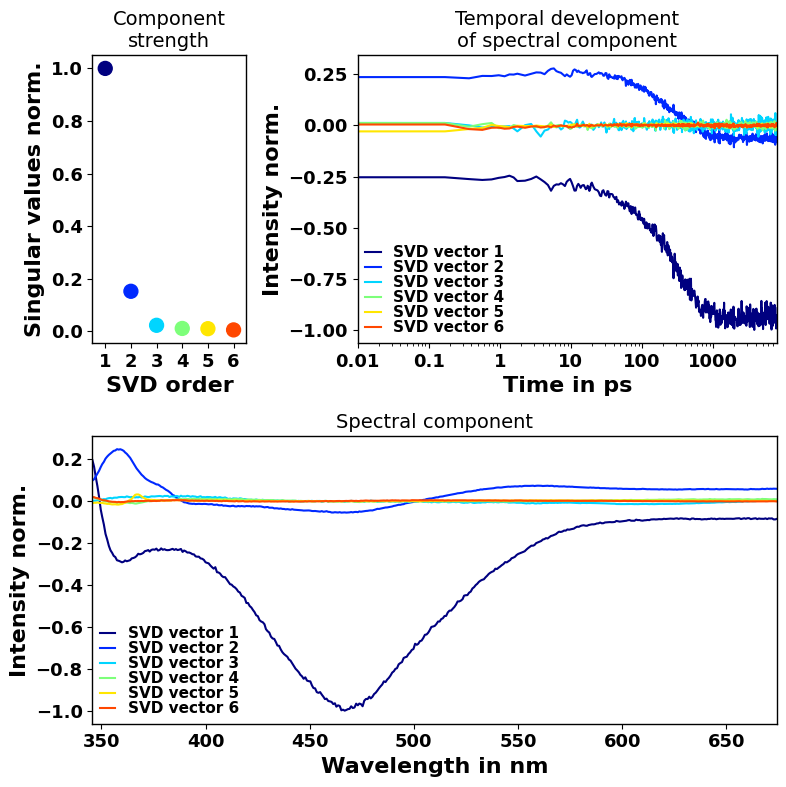

In [9]:
# plt.close("all")

ta = pf.TA(
    filename=sample, ds=df_data.T, sep=",", transpose=False, units="nm", baseunit="ps"
)
# ta.lintresh = 100
display(ta.ds)

# spectra
ta.wave_nm_bin = None
ta.rel_time = time_delays
# ta.time_width_percent=0
# ta.timelimits = [ylimit[0][0], ylimit[0][2]]
# ta.timelimits = [-30, 500]
# ta.ignore_time_region=[-0.5, 0.5]
ta.bordercut = nm_limit[0]  # wavelength range

# kinetics
ta.wavelength_bin = None
ta.rel_wave = wavelengths
# ta.scattercut=[300, 325]

# DA
ta.cmap = pf.cm.jet
ta.intensity_range = od_limit[0]
# ta.log_scale=False
# display(ta.ds)

# fit
ta.error_matrix_amplification = 10
ta.log_fit = False

# plot
# ta.log_scale=False
ta.Plot_RAW(
    plotting=[3],
    path=cwd,
    # scale_type="symlog"
)
# ta.Plot_Interactive()

## Parallel


### two components

In [ ]:
ta.mod = "paral"  # "exponential"
path = "p2"
# k0: s1 decay
# k1: t1 decay
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 35, vary=True)
ta.par.add("k1", value=1 / 30000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.2, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False)
ta.Plot_fit_output(path=path)

ta.Save_data(
    save_RAW=False,
    path=path,
    filename=filename.replace(".csv", "") + "_" + path,
    sep=",",
)
# ta.Save_Plots(
#              path=os.getcwd()+"/parallelST",
#              savetype="pdf",
#              filename=filename.replace(".csv", "") + "_parallelST",
# )

## Sequential


### two components

Exception in thread Thread-5 (listen):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keyboard/__init__.py", line 294, in listen
    _os_keyboard.listen(self.direct_callback)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keyboard/_darwinkeyboard.py", line 430, in listen
    raise OSError("Error 13 - Must be run as administrator")
OSError: Error 13 - Must be run as administrator



Fit Results:
Model Used: consecutive

The minimum error is:2.17177414e+03
The minimum R2-value is:9.94731567e-01

In Rates

+------------+-------------+--------------+--------+-------+-------+--------+
|            |       value |   init_value | vary   |   min |   max | expr   |
+============+=============+==============+========+=======+=======+========+
| k0         | 0.00322668  |       0.0025 | True   |     0 |   inf |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| k1         | 3.11731e-06 |       2e-05  | True   |     0 |   inf |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| t0         | 0.00164235  |       0      | True   |    -1 |     1 |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| resolution | 0.25        |       0.25   | False  |     0 |     1 |        |
+------------+-------------+--------------+--------+-------+-------+--------+

The rates conver

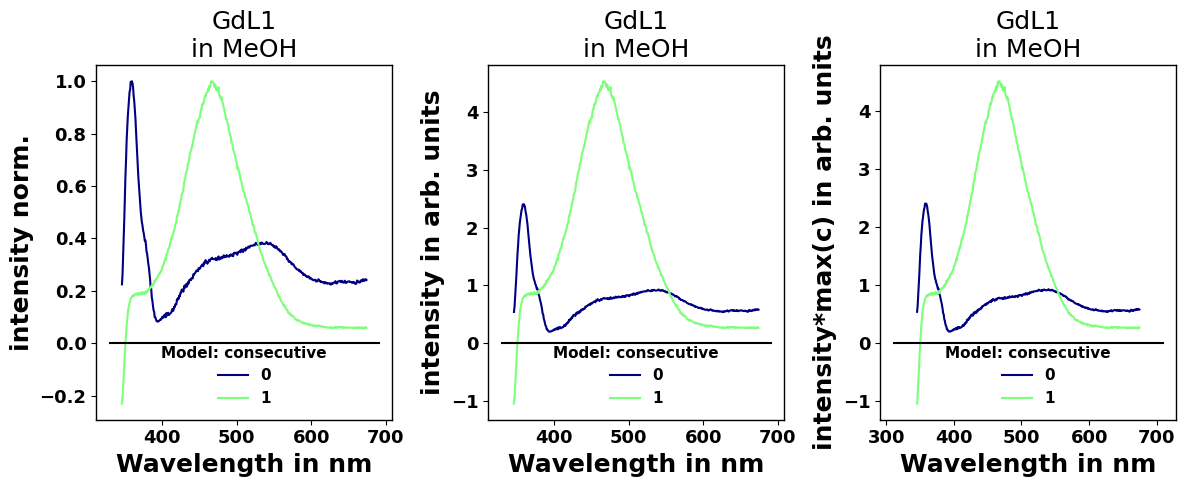

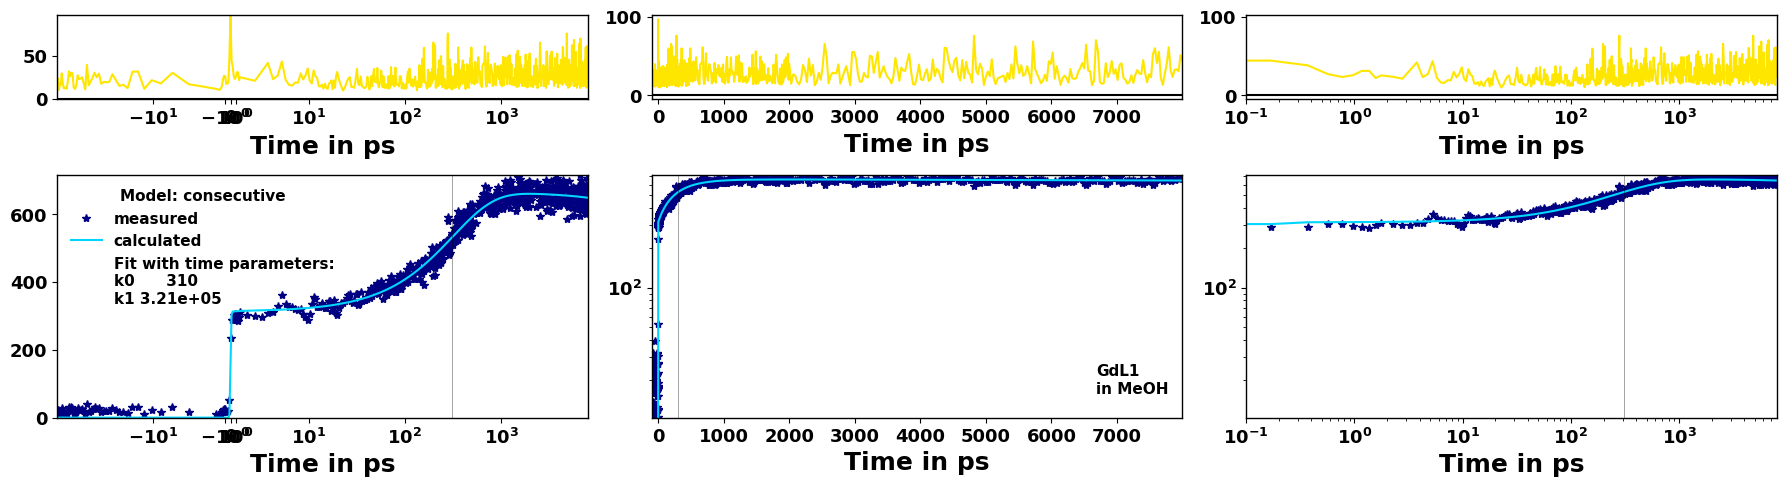

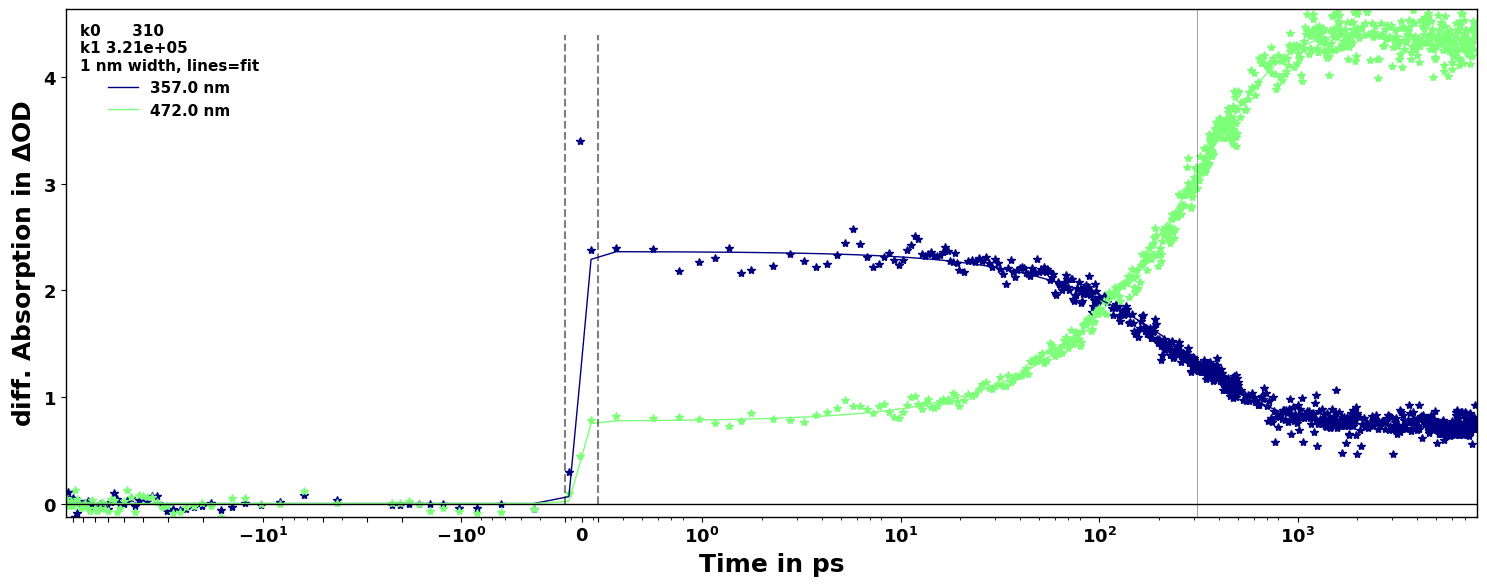

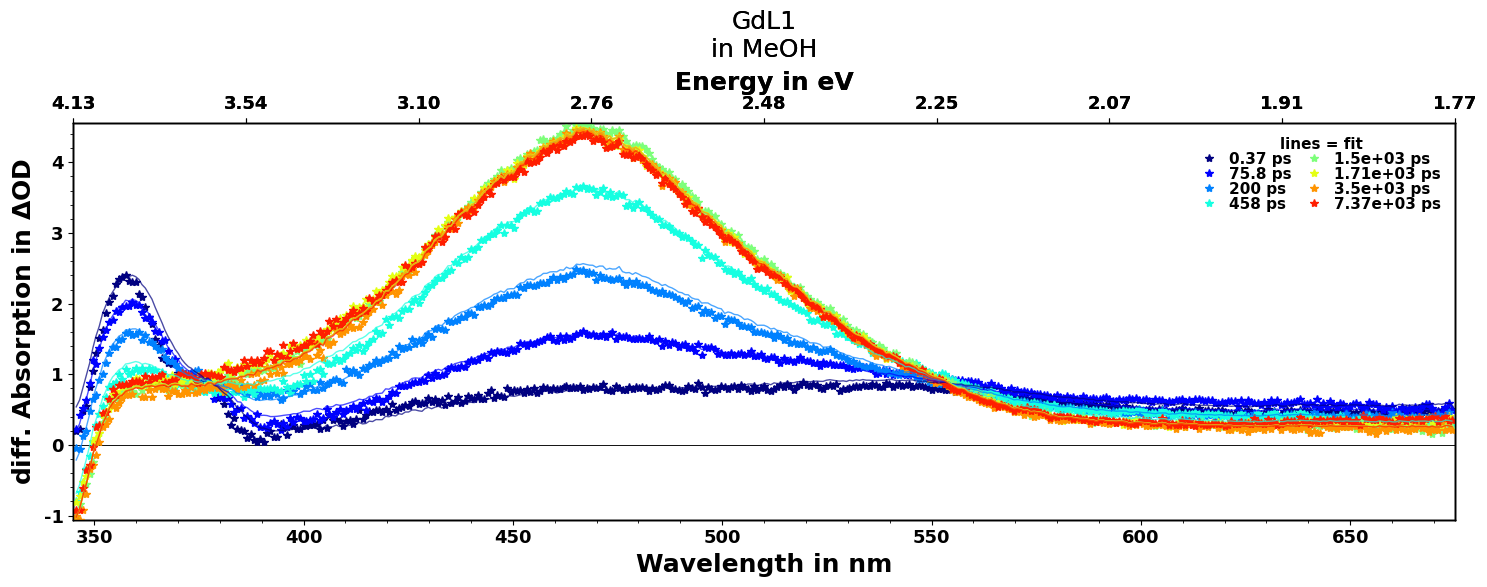

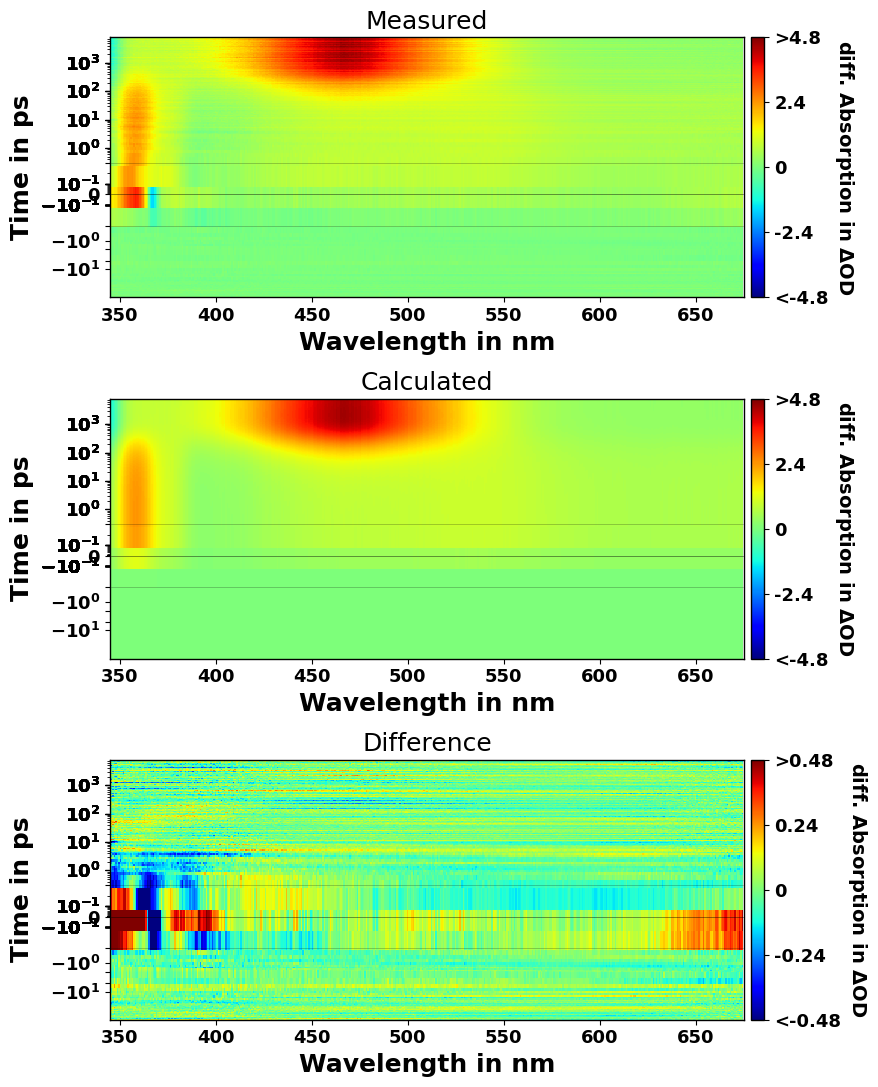

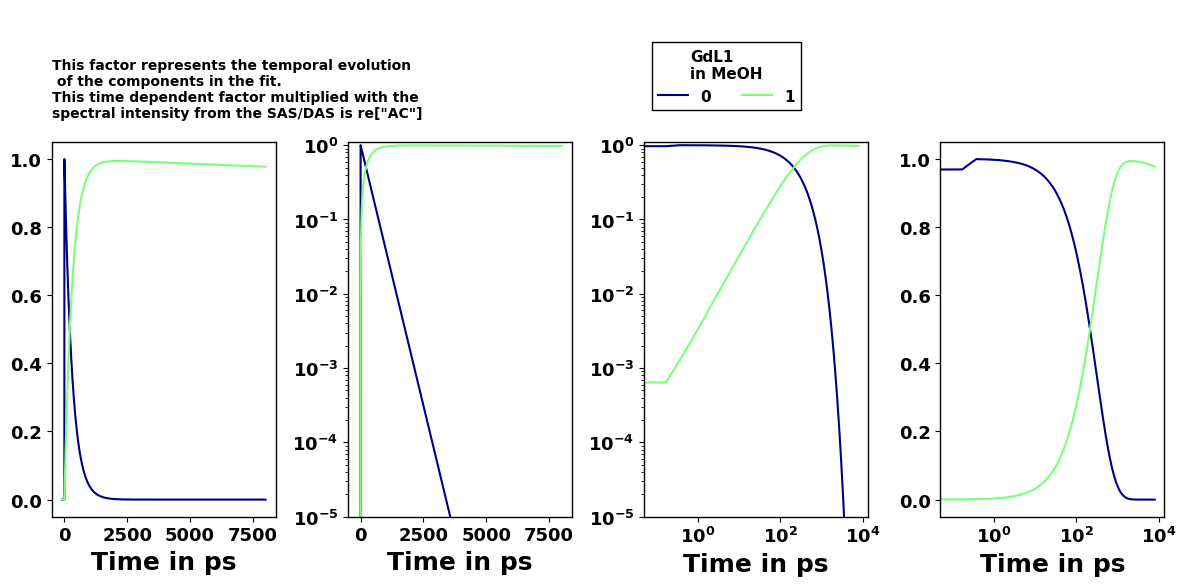

In [10]:
reload(mf)
reload(mp)

ta.mod = "consecutive"
path = "s2"
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 400, vary=True)
ta.par.add("k1", value=1 / 50000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.25, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False, sub_sample=10)
ta.Plot_fit_output(path=path)

df_fitted_data = ta.re["AC"].T
df_fitted_data.columns.name = None
df_fitted_data.index.name = None
df_fitted_data.to_csv(f"{path}/{filename}_data_gfit_{path}.csv", sep=",")

df_fitted_spectra = mins.extract_spectra_trspectra(df_fitted_data, time_delays)
df_fitted_spectra = df_fitted_spectra.rename(columns=lambda x: str(x) + "_fit")
df_fitted_spectra.to_csv(
    f"{path}/{filename}_spectra_gfit_{path}.csv", index_label="wl_nm"
)

df_fitted_kinetics = mins.extract_1colkinetics_trspectra(df_fitted_data, wavelengths)
df_fitted_kinetics = df_fitted_kinetics.rename(columns=lambda x: str(x) + "_fit")
df_fitted_kinetics.to_csv(
    f"{path}/{filename}_kinetics_gfit_{path}.csv", index_label="time_ps"
)

df_fitted_das = ta.re["DAC"]
df_fitted_das.index.name = "wl_nm"
df_fitted_das.to_csv(f"{path}/{filename}_das_gfit_{path}.csv", sep=",")

df_fitted_conc = ta.re["c"]
df_fitted_conc.index.name = "time_ps"
df_fitted_conc.to_csv(f"{path}/{filename}_conc_gfit_{path}.csv", sep=",")

### three components


In [ ]:
reload(mf)
reload(mp)

ta.mod = "consecutive"
path = "s3"
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 0.1, vary=True)
ta.par.add("k1", value=1 / 10, vary=True)
ta.par.add("k2", value=1 / 600, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.25, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False, sub_sample=10)
ta.Plot_fit_output(path=path)

df_fitted_data = ta.re["AC"].T
df_fitted_data.columns.name = None
df_fitted_data.index.name = None
df_fitted_data.to_csv(f"{path}/{filename}_{path}_data_gfit_{path}.csv", sep=",")

df_fitted_spectra = mins.extract_spectra_trspectra(df_fitted_data, time_delays)
df_fitted_spectra = df_fitted_spectra.rename(columns=lambda x: str(x) + "_fit")
df_fitted_spectra.to_csv(
    f"{path}/{filename}_spectra_gfit_{path}.csv", index_label="wl_nm"
)

df_fitted_kinetics = mins.extract_1colkinetics_trspectra(df_fitted_data, wavelengths)
df_fitted_kinetics = df_fitted_kinetics.rename(columns=lambda x: str(x) + "_fit")
df_fitted_kinetics.to_csv(
    f"{path}/{filename}_kinetics_gfit_{path}.csv", index_label="time_ps"
)

df_fitted_das = ta.re["DAC"]
df_fitted_das.index.name = "wl_nm"
df_fitted_das.to_csv(f"{path}/{filename}_das_gfit_{path}.csv", sep=",")

df_fitted_conc = ta.re["c"]
df_fitted_conc.index.name = "time_ps"
df_fitted_conc.to_csv(f"{path}/{filename}_conc_gfit_{path}.csv", sep=",")

### four components


In [ ]:
reload(mf)
reload(mp)

ta.mod = "consecutive"
path = "s4"
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 0.1, vary=True)
ta.par.add("k1", value=1 / 10, vary=True)
ta.par.add("k2", value=1 / 200, vary=True)
ta.par.add("k3", value=1 / 5000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.25, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False, sub_sample=10)
ta.Plot_fit_output(path=path)

df_fitted_data = ta.re["AC"].T
df_fitted_data.columns.name = None
df_fitted_data.index.name = None
df_fitted_data.to_csv(f"{path}/{filename}_{path}_data_gfit_{path}.csv", sep=",")

df_fitted_spectra = mins.extract_spectra_trspectra(df_fitted_data, time_delays)
df_fitted_spectra = df_fitted_spectra.rename(columns=lambda x: str(x) + "_fit")
df_fitted_spectra.to_csv(
    f"{path}/{filename}_spectra_gfit_{path}.csv", index_label="wl_nm"
)

df_fitted_kinetics = mins.extract_1colkinetics_trspectra(df_fitted_data, wavelengths)
df_fitted_kinetics = df_fitted_kinetics.rename(columns=lambda x: str(x) + "_fit")
df_fitted_kinetics.to_csv(
    f"{path}/{filename}_kinetics_gfit_{path}.csv", index_label="time_ps"
)

df_fitted_das = ta.re["DAC"]
df_fitted_das.index.name = "wl_nm"
df_fitted_das.to_csv(f"{path}/{filename}_das_gfit_{path}.csv", sep=",")

df_fitted_conc = ta.re["c"]
df_fitted_conc.index.name = "time_ps"
df_fitted_conc.to_csv(f"{path}/{filename}_conc_gfit_{path}.csv", sep=",")

## Target

### two components


In [ ]:
ta.mod = mm.targetST
path = "t2"
# k0: s1 decay
# k1: ISC
# k2: t1 decay
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 4600, vary=True)
ta.par.add("k1", value=1 / 8, vary=True)
ta.par.add("k2", value=1 / 4600, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.20, min=0, max=1, vary=True)
ta.Fit_Global(fit_chirp=False, sub_sample=10)
ta.Plot_fit_output(path=path)

ta.Save_data(
    save_RAW=False,
    path=path,
    filename=filename.replace(".csv", "") + "_" + path,
    sep=",",
)

## Visualize Global Fitting

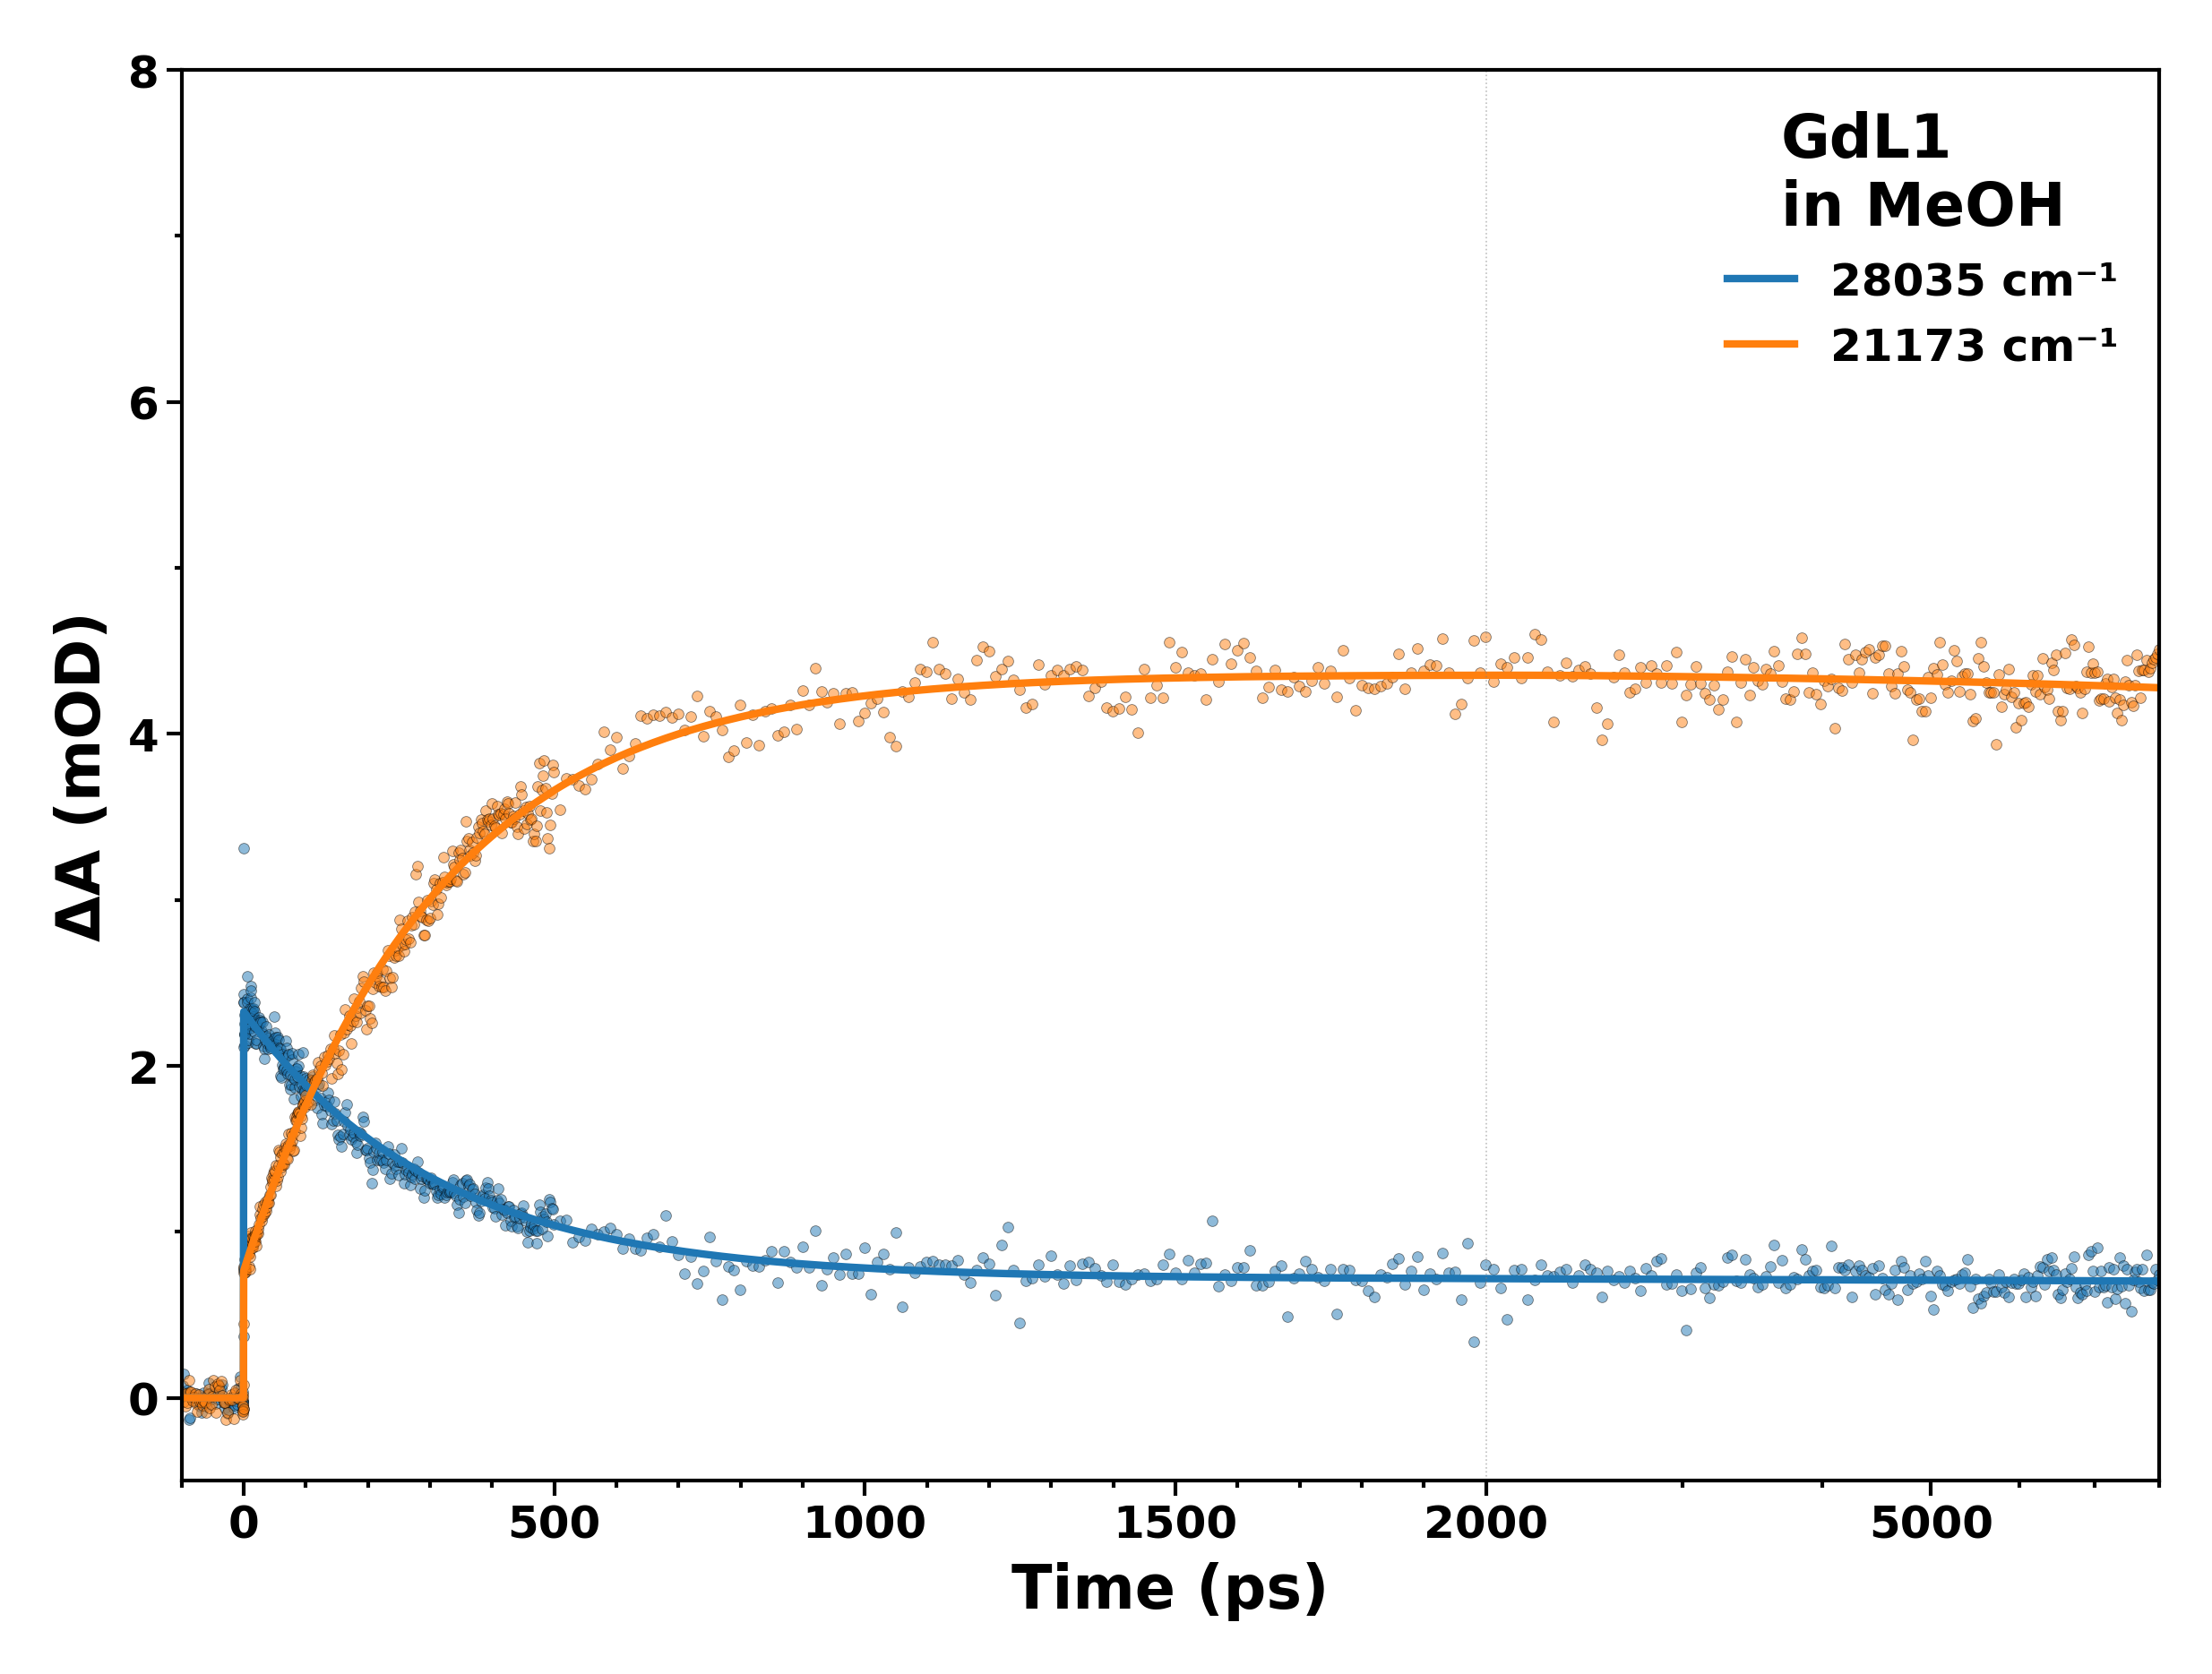

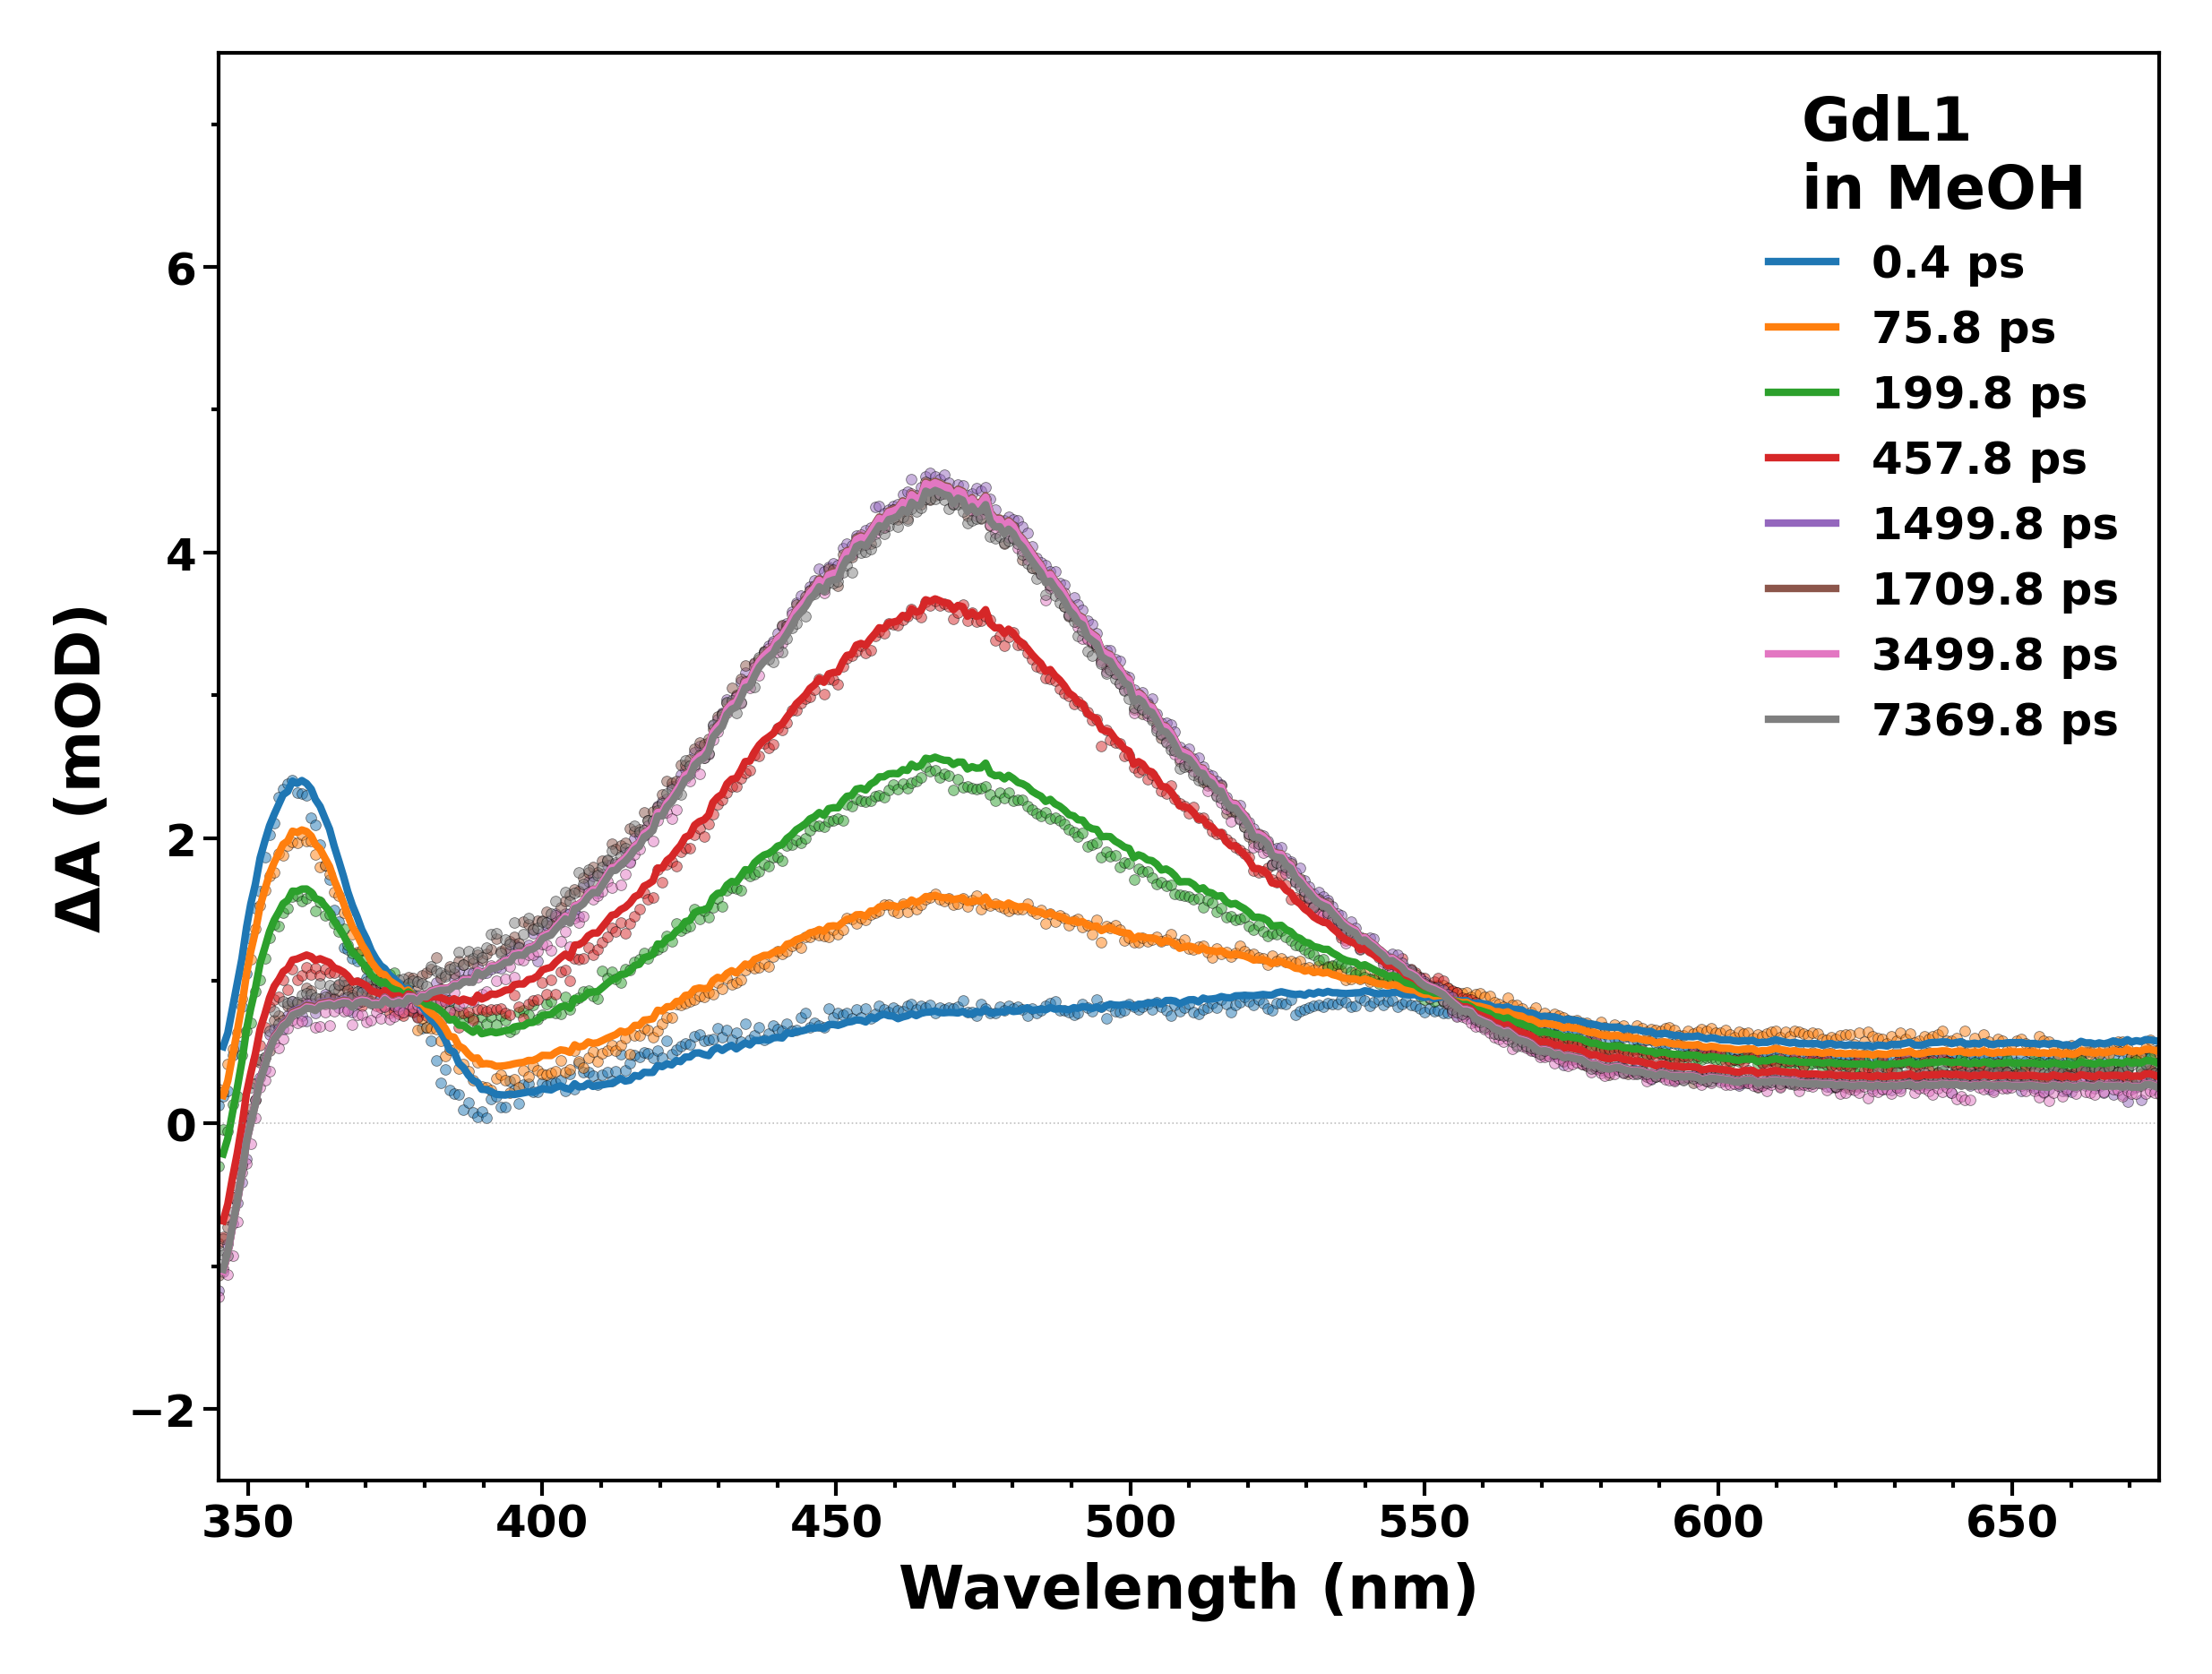

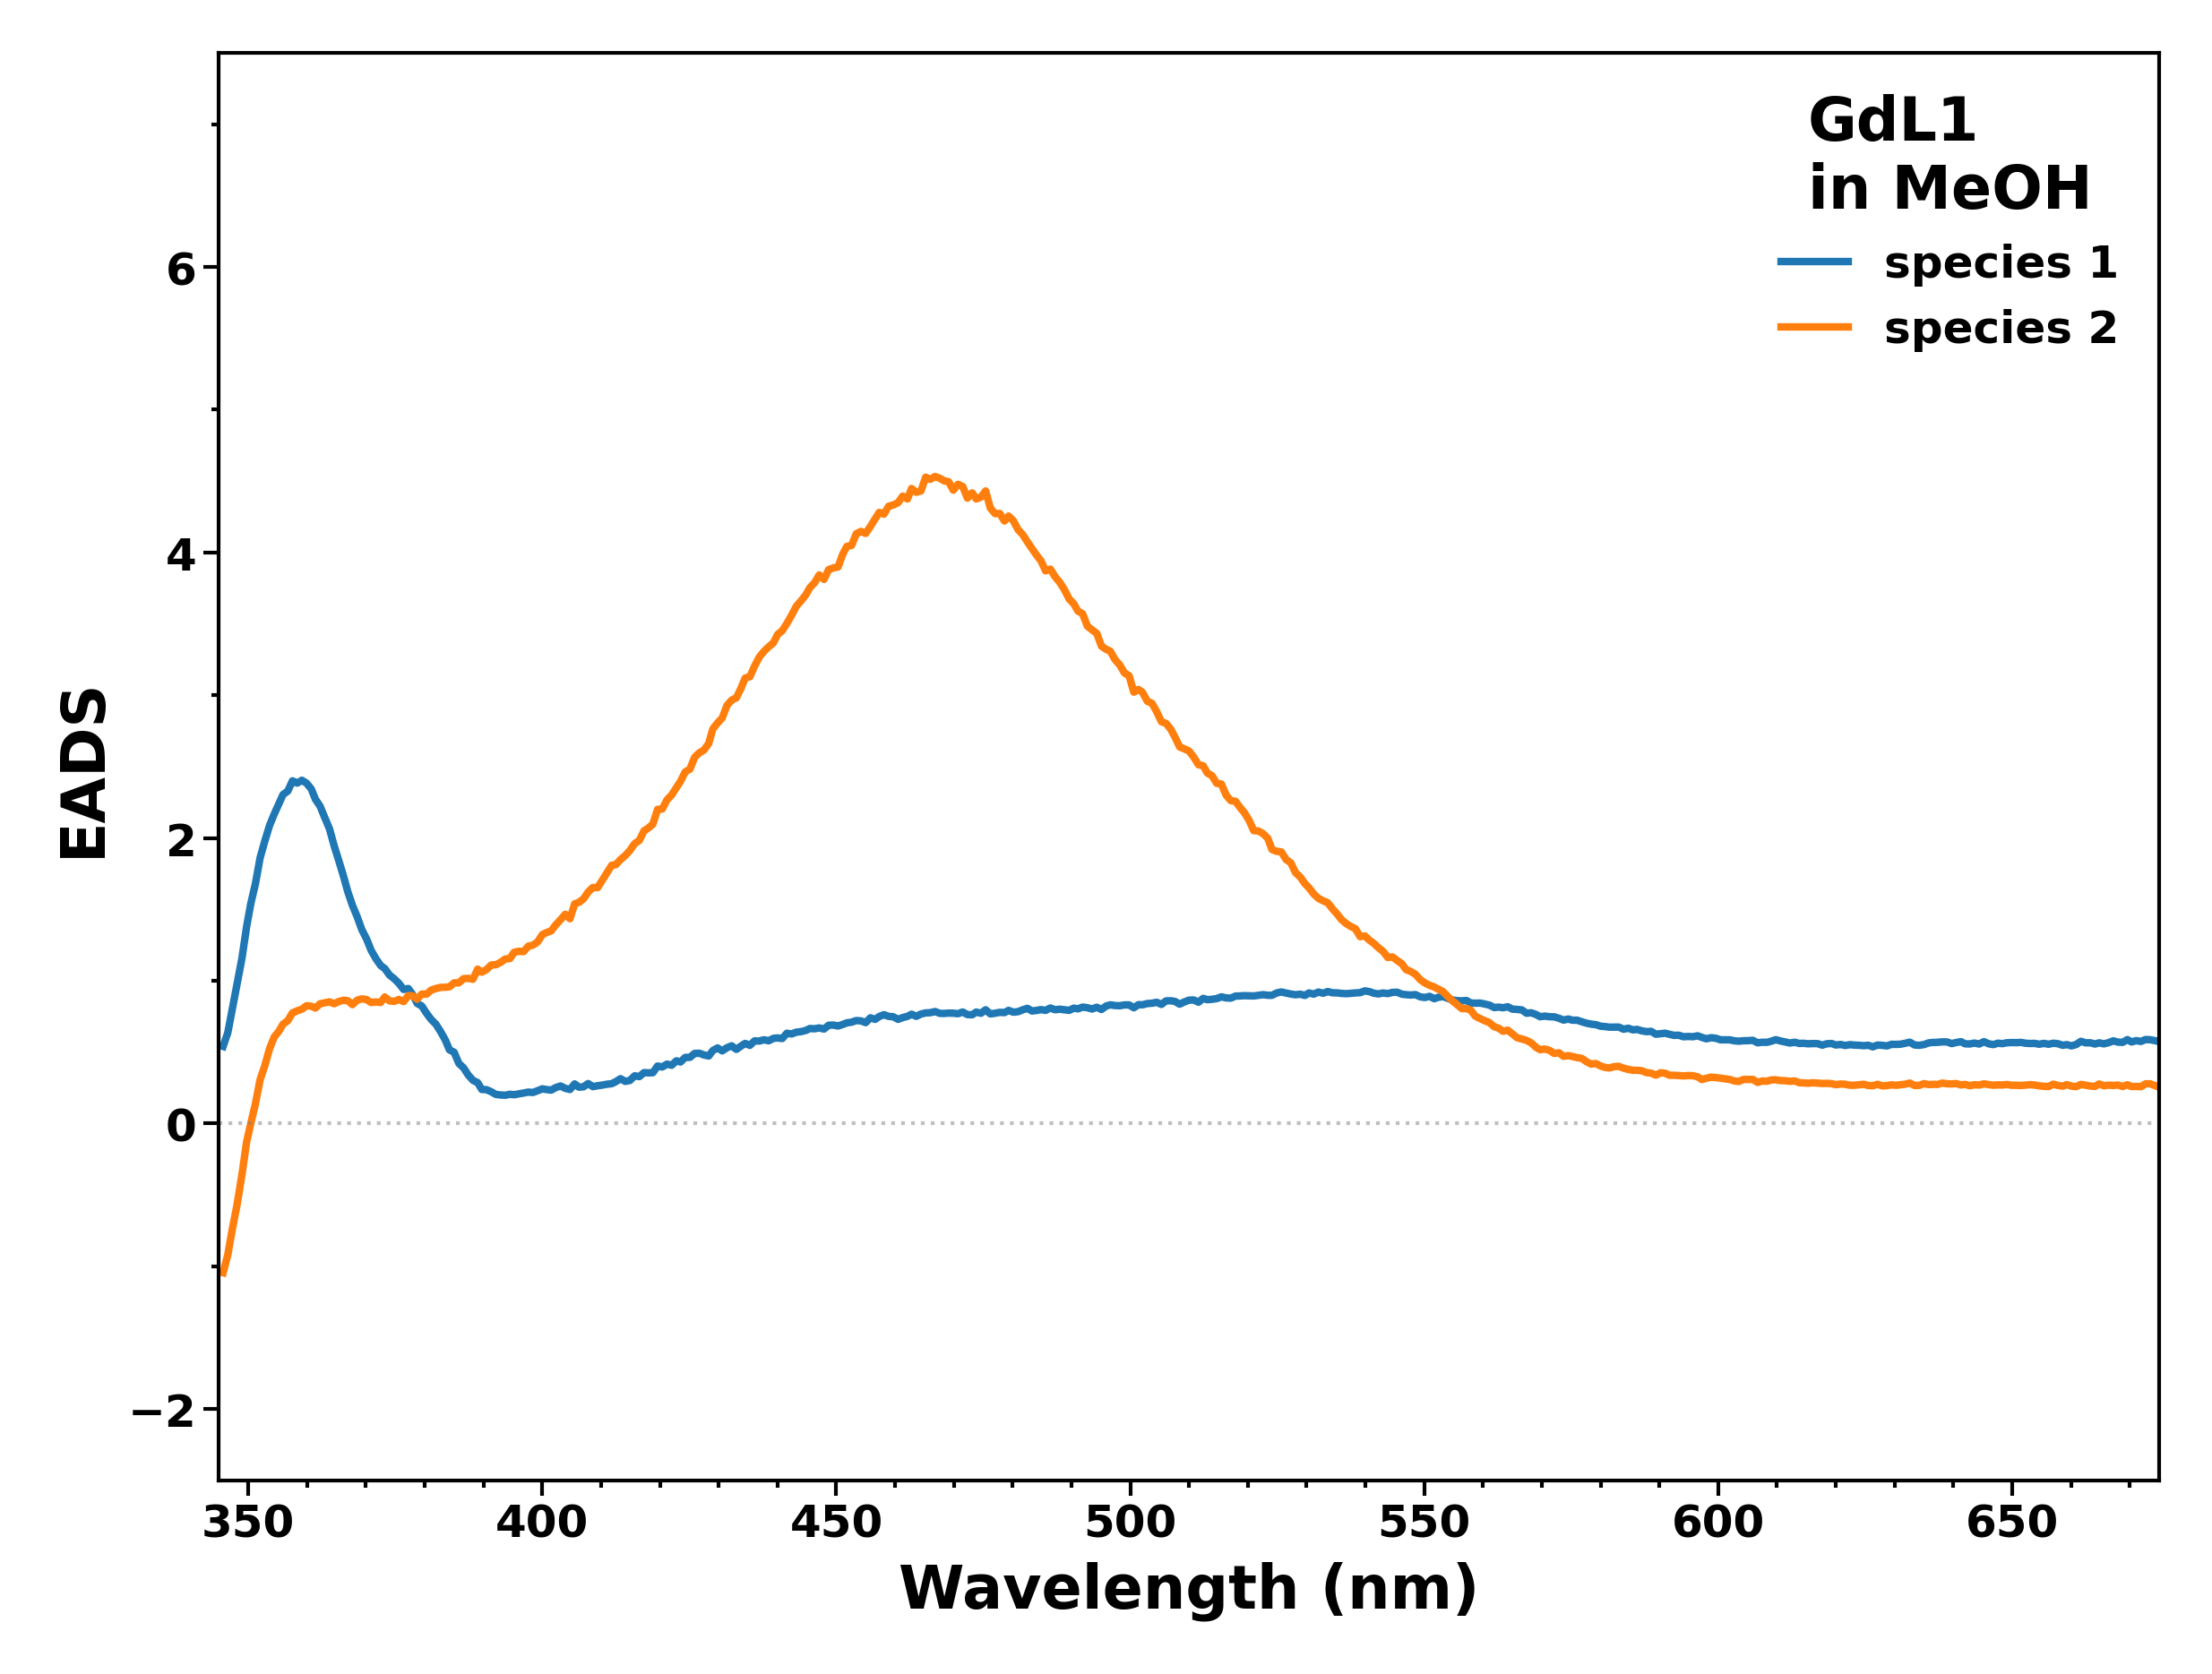

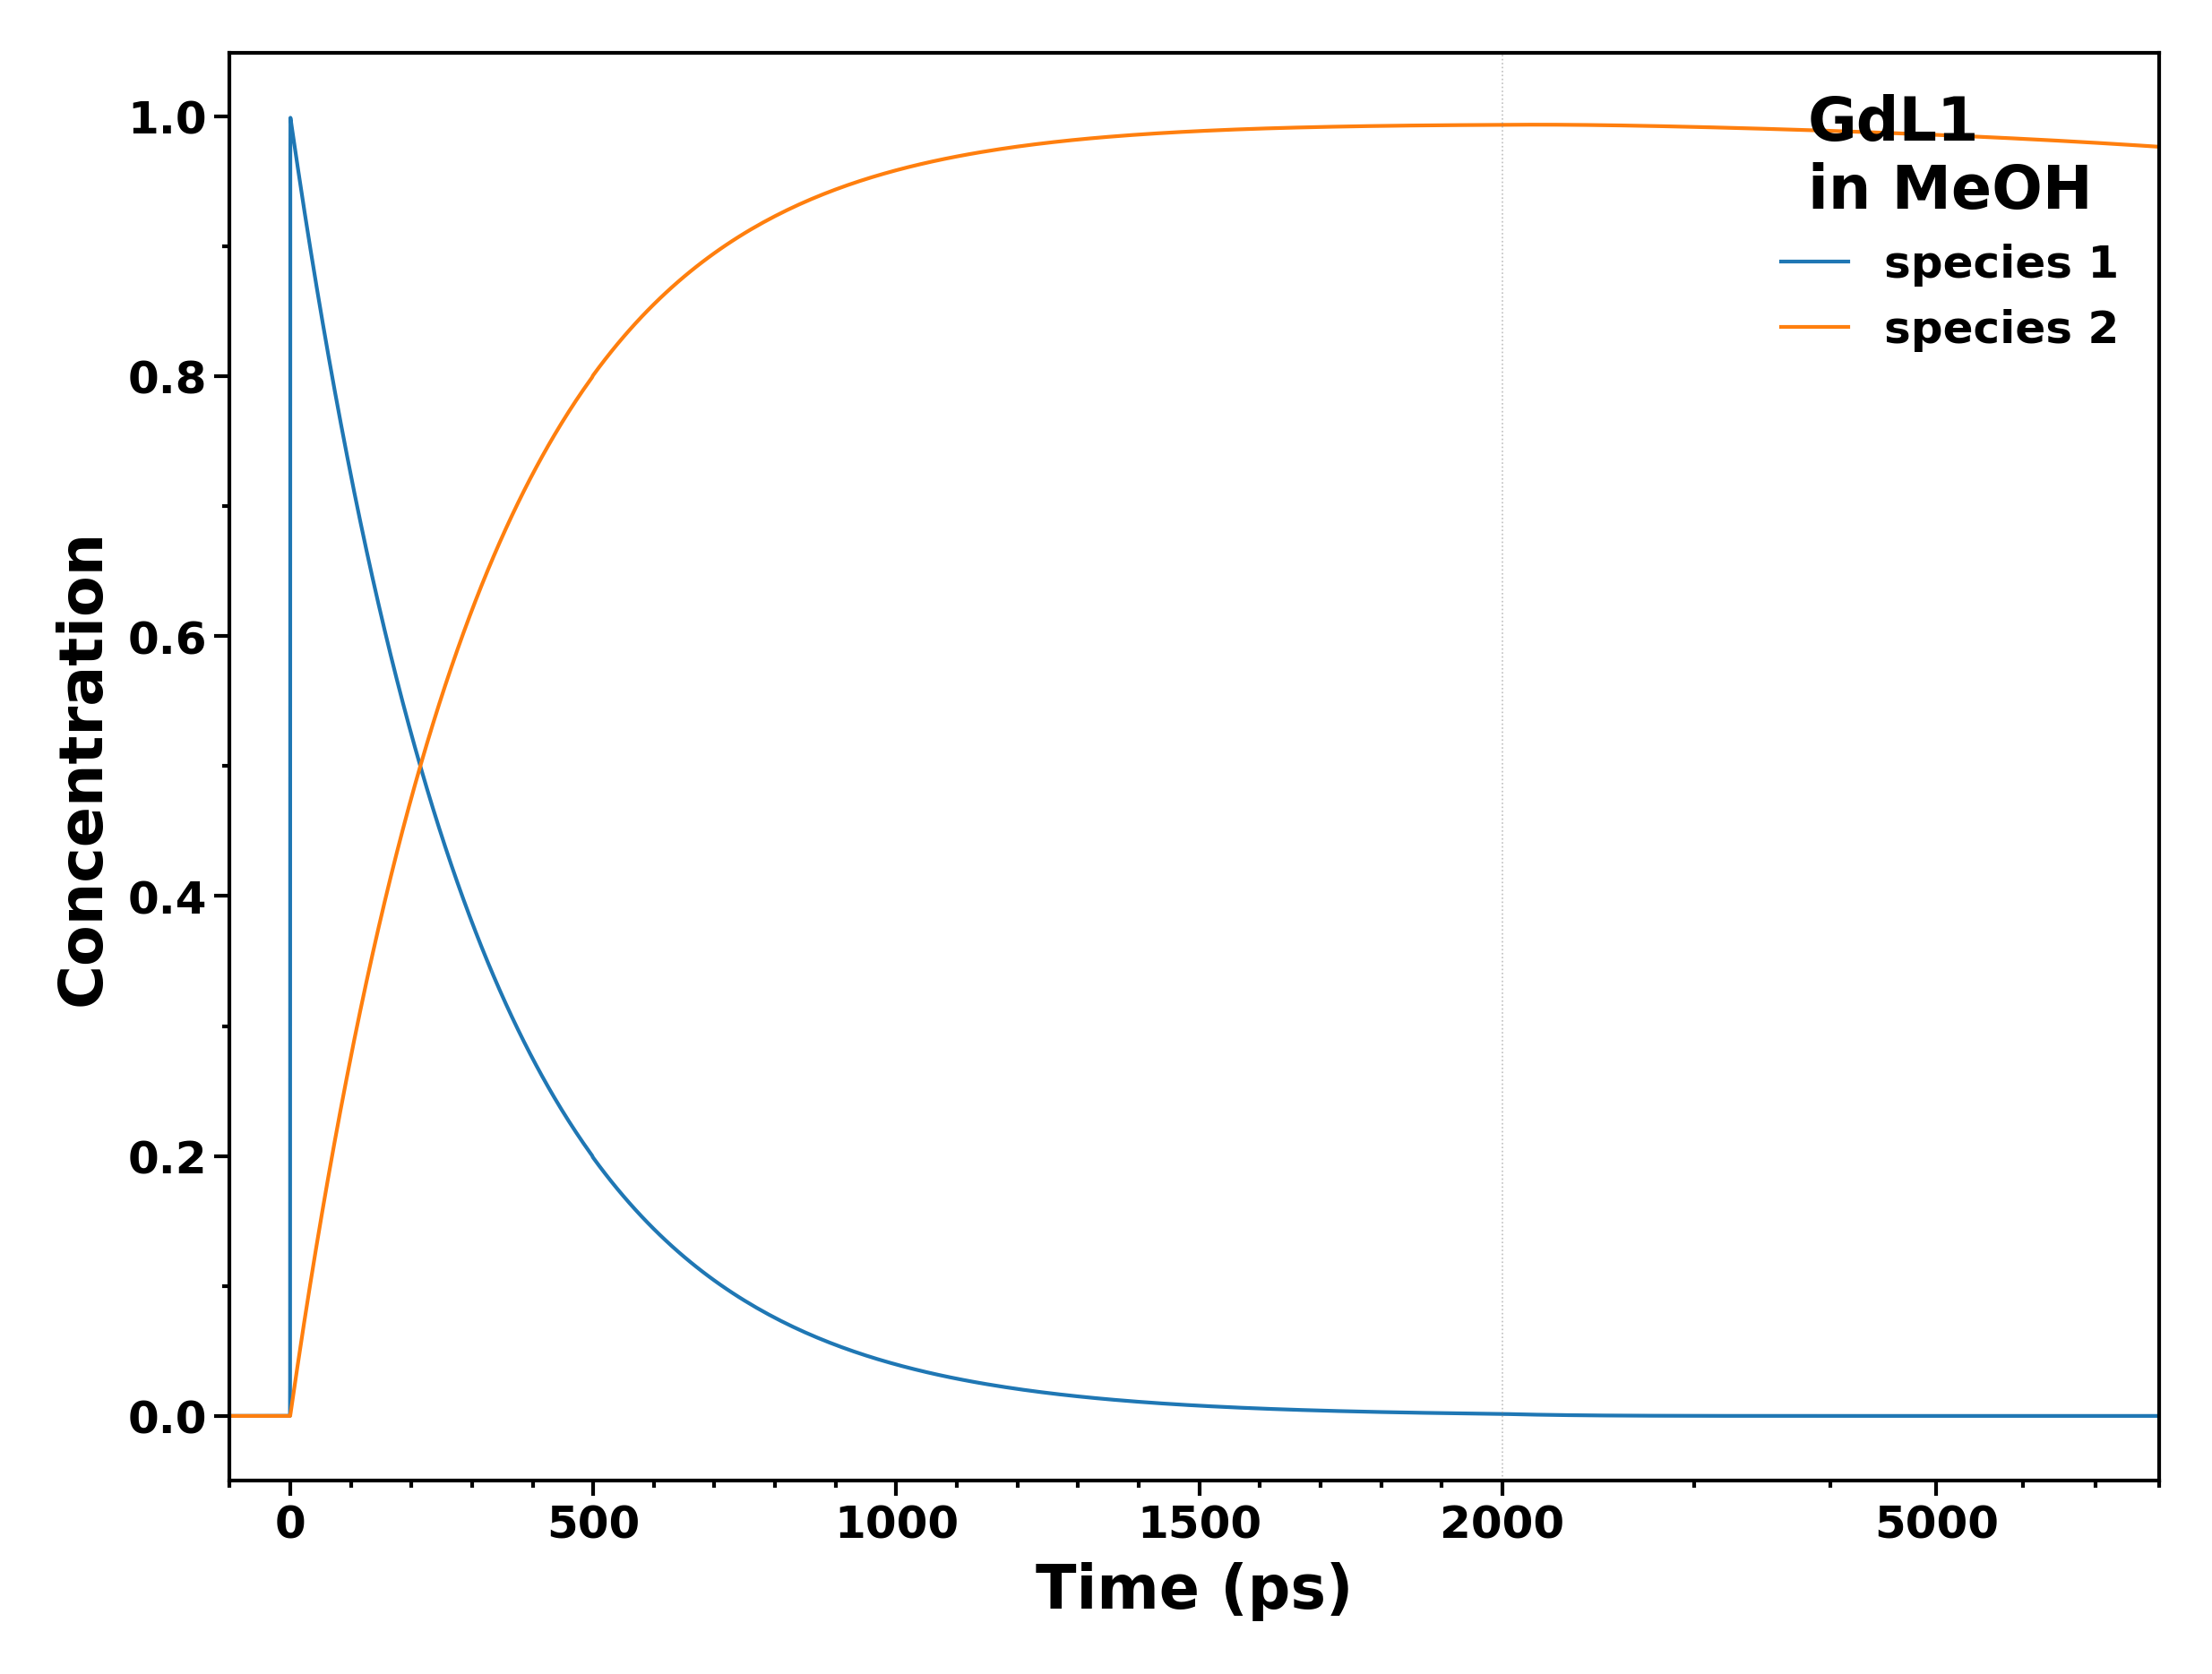

In [11]:
reload(mp)
reload(mf)

folder_fitting_results = "s2"

fp_kinetics = glob.glob(f"*_kinetics.csv")
df_kinetics = pd.read_csv(fp_kinetics[0], header=0, index_col=0, sep=",")
fp_fitted_kinetics = glob.glob(
    f"{folder_fitting_results}/*_kinetics_gfit_{folder_fitting_results}.csv"
)
df_fitted_kinetics = pd.read_csv(fp_fitted_kinetics[0], header=0, index_col=0, sep=",")
fig_fitted_kinetics = mp.display_fsta_fitted_kinetics_symlog(
    list_df=[df_kinetics, df_fitted_kinetics],
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendtitle=sample,
    # legendposition="upper left",
    showwn=True,
)
plt.show()
fig_fitted_kinetics.savefig(f"{path}/{filename}_kinetics_gfit_{path}.svg")

fp_spectra = glob.glob(f"*_spectra.csv")
df_spectra = pd.read_csv(fp_spectra[0], header=0, index_col=0, sep=",")
fp_fitted_spectra = glob.glob(
    f"{folder_fitting_results}/*_spectra_gfit_{folder_fitting_results}.csv"
)
df_fitted_spectra = pd.read_csv(fp_fitted_spectra[0], header=0, index_col=0, sep=",")
fig_fitted_spectra = mp.display_fsta_fitted_spectra_bnm(
    list_df=[df_spectra, df_fitted_spectra],
    xlimit=nm_limit,
    ylimit=spectra_od_limit,
    legendtitle=sample,
    # legendposition="upper left",
)
plt.show()
fig_fitted_spectra.savefig(f"{path}/{filename}_spectra_gfit_{path}.svg")

fp_fitted_das = glob.glob(
    f"{folder_fitting_results}/*_das_gfit_{folder_fitting_results}.csv"
)
df_fitted_das = pd.read_csv(fp_fitted_das[0], header=0, index_col=0, sep=",")
fig_fitted_das = mp.display_fsta_globalfit_das_bnm(
    df_das_wl=df_fitted_das,
    xlimit=nm_limit,
    ylimit=spectra_od_limit,
    ylabel="EADS",
    legendtitle=sample,
    # legendtext=[
    #     f"A k\u2081\u207b\u00b9 = {tau1}",
    #     f"B k\u2082\u207b\u00b9 = {tau2}",
    # ],
    # legendposition="upper left",
)
plt.show()
fig_fitted_das.savefig(f"{path}/{filename}_das_gfit_{path}.svg")

fp_fitted_conc = glob.glob(
    f"{folder_fitting_results}/*_conc_gfit_{folder_fitting_results}.csv"
)
df_fitted_conc = pd.read_csv(fp_fitted_conc[0], header=0, index_col=0, sep=",")
fig_fitted_conc = mp.display_fsta_globalfit_conc_symlog(
    df_1col=df_fitted_conc,
    xlimit=kinetics_t_limit,
    # ylimit=od_limit,
    legendtitle=sample,
    # legendtext=["A", "B", "C"],
    # legendtext=["S\u2081", "T\u2081"],
)
plt.show()
fig_fitted_conc.savefig(f"{path}/{filename}_conc_gfit_{path}.svg")